# Uncertainty with Bayesian Neural Networks

**Bayesian Neural Networks** (BNN) can be understood as a combination of neural networks and bayesian inference. In traditional deep learning, weights are fixed values (initially random), that we iteratively update via gradient descent. BNN on the other hand learn __distribution parameters over weights__, these distribution parameters are learned using bayesian inference. This approaches allows, among others, to measure uncertainty among predictions.

# Bayesian inference 

In bayesian inference we try to compute $p(w | D_{train})$, the conditional distribution of the weights given the data, aka the *posterior distribution*, rather than static parameters values. 

### Exact Bayesian Inference

Thanks to Bayes' rule we can compute the posterior : 

\begin{align*}
    p(w | D) & = \frac{p(D | w)p(w)}{p(D)}\\
             & = \frac{p(D | w)p(w)}{\int_w' p(D | w')p(w')} \\
\end{align*}

With $\hat{y}$ the predicted output as a function of the input $x$, The posterior distribution over the weights allows us to compute the __predictive distribution__ : 

\begin{align*}
    p(\hat{y}(x) | D) = \int_w p(\hat{y}(x) | w) p(w | D) dw = \mathbb{E}_{p(w | D)} [p(\hat{y}(x) | w)]
\end{align*}

which can be useful to describe the epistemic uncertainty of our model. We will come back later on the uncertainty.

Computing the posterior in this way can be called *exact inference*, and needs the *prior* $p(w)$ and the *likelihood* $p(D | w)$ of the data. Unfortunately in the expression of the posterior and the predictive distribution we need to integrate over the weight space which can be intractable, in order to adresses theses issues we use a set of tools that allow us to do approximate inference. There is two family of approximate inference methods : sampling and variational, we will focus on variational methods.

### Variational inference

The spirit of variational inference is, when facing an intractable posterior $p(w | D)$, to surrogate it with a parametrized distribution $q_{\phi}(w)$, namely the *approximate posterior*. This surrogate distribution will be optimised (by tuning its parameters $\phi$) in order to be as close as possible to the original posterior. In practice the choice of the approximate distribution can be seen as an hyperparameter. Two main questions arise from this : 

* **How to check if the surrogate is close to the true posterior ?** 
* **How to maximize the similarity of our distributions ?**


### Measure of similarity : 

The Kullback-Liebler divergence is a metric that allows us to mesure the similiarity between two distribution. it is defined by the expectation of the log ratio between the two distributions : 

\begin{align*}
    D_{KL}(P \| Q) = \mathbb{E} \left[log \frac{P}{Q}\right]
\end{align*}

in our case : 

\begin{align*}
    D_{KL} (q_{\phi}(w) \| p(w | D)) & = \mathbb{E}_{q_{\phi}(w)}\left[log \frac{q_{\phi}(w)}{p(w |D)} \right] \\
                                    & = \int_w q_\phi (w) log \frac{q_\phi (w)}{p(w |D)}
\end{align*}


The KL divergence is a non-negative measure of similarity, that is 0 for identical distributions
... 

### Derive a tractable optimization problem : 

We have an intractable posterior $p(w | W)$, a surrogate distribution $q_{\phi}(w)$, a way to measure their similarity  $D_{KL} (q_{\phi}(w) \| p(w | D))$, now we need find a way to minimize their dissimilarity. To do this we will formulate it as an optimization problem. 

Directly minimizing  $D_{KL} (q_{\phi}(w) \| p(w | D))$ is 
difficult as $p(w | D)$ is still intractable. To bypass this we will derive a related quantity, equal to the KL divergence plus a constant, that will be our new objective.

\begin{align*}
    D_{KL} (q_{\phi}(w) \| p(w | D)) & = \mathbb{E}_{q_{\phi}(w)}\left[log \frac{q_{\phi}(w)}{p(w |D)} \right] \\
                                     & = \mathbb{E}_{q_{\phi}(w)}\left[log(q_{\phi}(w)) - log (p(w |D)) \right] \\
                                     & = \mathbb{E}_{q_{\phi}(w)}\left[log(q_{\phi}(w))\right] - \mathbb{E}_{q_{\phi}(w)}\left[log (p(D, w)) - log (p(D)) \right] \\        
                                     & = \mathbb{E}_{q_{\phi}(w)}\left[log(q_{\phi}(w))\right] - \mathbb{E}_{q_{\phi}(w)}\left[log (p(D, w))\right] + log p(D)\\                   
\end{align*}

thus 

\begin{align*} 
    log p(D) \geq \mathbb{E}_{q_{\phi}(w)}\left[log q_{\phi}(w) - log p(w, D)\right] \;\;\;\;\;\;\;\; \;\;\;\;\;\;\;\;\; [\small{\text{as}\;\;\; D_{KL}(q \| p) \geq 0}]
\end{align*}


# Import, data and utils functions 

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

/tmp/ipykernel_17284/2317591137.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-10 18:30:13.312504: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-10 18:30:13.522976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 18:30:13.523072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin

# Dataset

- Basic non-linear dataset for a classification problem

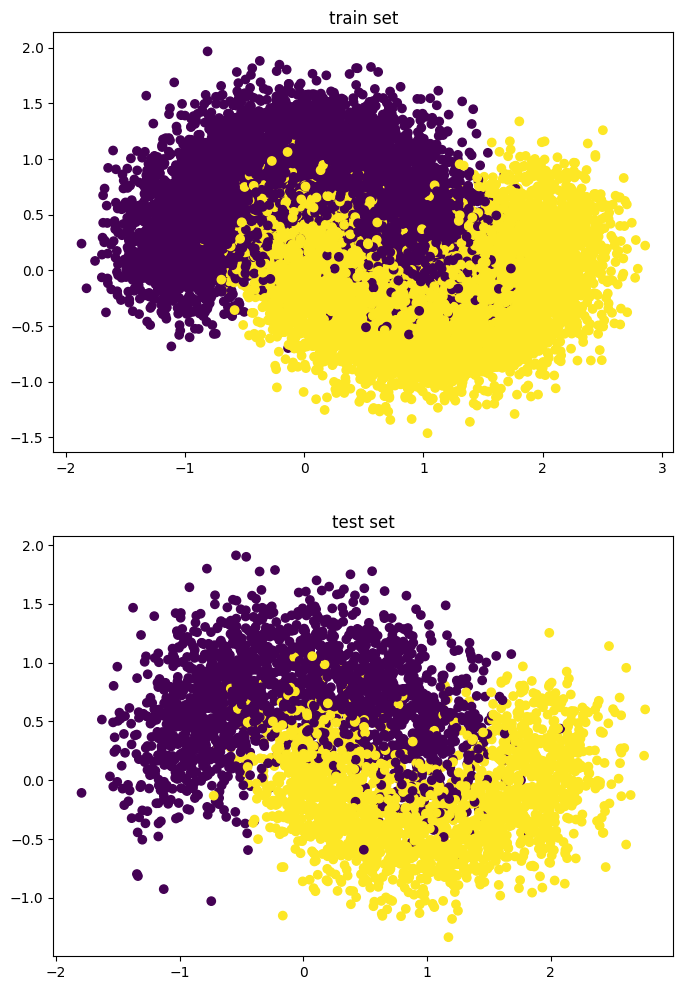

In [2]:
X, y = make_moons(n_samples=20000, noise=0.3)
y = y.reshape(-1,1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_test = tf.cast(X_test, tf.float32)
X_train = tf.cast(X_train, tf.float32)
y_test = tf.cast(y_test, tf.float32)
y_train = tf.cast(y_train, tf.float32)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
ax1.scatter(X_train[:,0], X_train[:,1], c=y_train)
ax1.set_title('train set')
ax2.scatter(X_test[:,0], X_test[:,1], c=y_test)
ax2.set_title('test set')

plt.show()

# Baseline model
traditional deep net

In [3]:
def create_network(units=100, activation='relu', lr=0.01) : 
    
    inputs = keras.Input(shape=(X_train.shape[1],))
    
    hidden1 = Dense(units, activation=activation)(inputs)
    hidden1 = BatchNormalization()(hidden1)
    
    hidden2 = Dense(units, activation=activation)(hidden1)
    hidden2 = BatchNormalization()(hidden2)
    
    hidden3 = Dense(units, activation=activation)(hidden2)
    hidden3 = BatchNormalization()(hidden3)
    
    outputs = Dense(1, activation='sigmoid')(hidden3)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='baseline')

    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['Accuracy'])
    model.summary()
    return model

In [4]:
baseline = create_network()
baseline.fit(X_train, y_train, batch_size=32, verbose=0, epochs=20) 

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 100)               300       
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 100)               101

- Evaluate the model

accuracy :  0.91675


Text(0.5, 1.0, 'predictions')

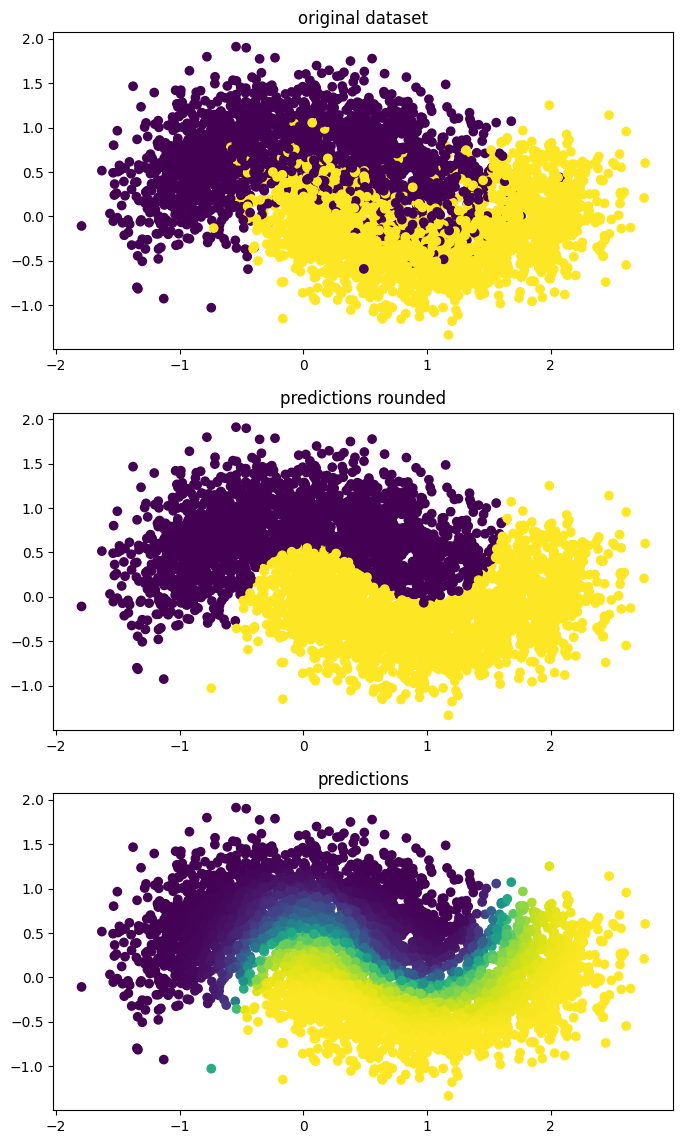

In [5]:
y_pred = np.asarray(baseline(X_test))

print('accuracy : ', accuracy_score(y_test, y_pred.round()))

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(8, 14))
ax1.scatter(X_test[:,0], X_test[:,1], c=y_test)
ax1.set_title('original dataset')

ax2.scatter(X_test[:,0], X_test[:,1], c=y_pred.round())
ax2.set_title('predictions rounded')

ax3.scatter(X_test[:,0], X_test[:,1], c=y_pred)
ax3.set_title('predictions')


* ### Aleatoric uncertainty (aka statistical) : 
referts to the notion of randomness, i.e variability in the outcome of an experiment which is due to inherently random effects.

To allow a model to capture the aleatoric uncertainty we will output not a point estimate as usual but a probability distribution. In the case of binary classification the output will be a bernoulli distribution.

As the output is no more a single estimate we need to change the loss function, we will use the **negative loglieklihood**, in order to get how likely it is to encounter targets in our data from the estimated distribution of the model.

In [43]:
def nll(y, y_pred): 
  return -y_pred.log_prob(y)

In [36]:
def create_aleatoric_model(units=100, activation='relu', lr=0.001):

  inputs = keras.Input(shape=(X_train.shape[1],))

  hidden1 = Dense(units, activation=activation)(inputs)
  hidden1 = BatchNormalization()(hidden1)
  hidden1 = Dropout(0.1)(hidden1)

  hidden2 = Dense(units, activation=activation)(hidden1)
  hidden2 = BatchNormalization()(hidden2)
  hidden2 = Dropout(0.1)(hidden2)
  
  hidden3 = Dense(units, activation=activation)(hidden2)
  hidden3 = BatchNormalization()(hidden3)
  hidden3 = Dropout(0.1)(hidden3)

  # output Bernoulli distribution ! 
  outputs = Dense(tfp.layers.IndependentBernoulli.params_size(1))(hidden3)  
  outputs = tfp.layers.IndependentBernoulli(1)(outputs)

  model = keras.Model(inputs=inputs, outputs=outputs, name='aleatoric_BNN')

  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss=nll, optimizer=opt, metrics=['Accuracy'])
  model.summary()
  return model

In [39]:
aleatoric_model = create_aleatoric_model()
aleatoric_model.fit(X_train, y_train, batch_size=32, verbose=0, epochs=20) 

Model: "aleatoric_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_30 (Dense)            (None, 100)               300       
                                                                 
 batch_normalization_17 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_31 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_18 (Ba  (None, 100)               400       
 tchNormalization)                                   

The standard deviation of the outputed distribution will represent te aleatoric uncertainty associated with the dataset :  

accuracy :  0.91075


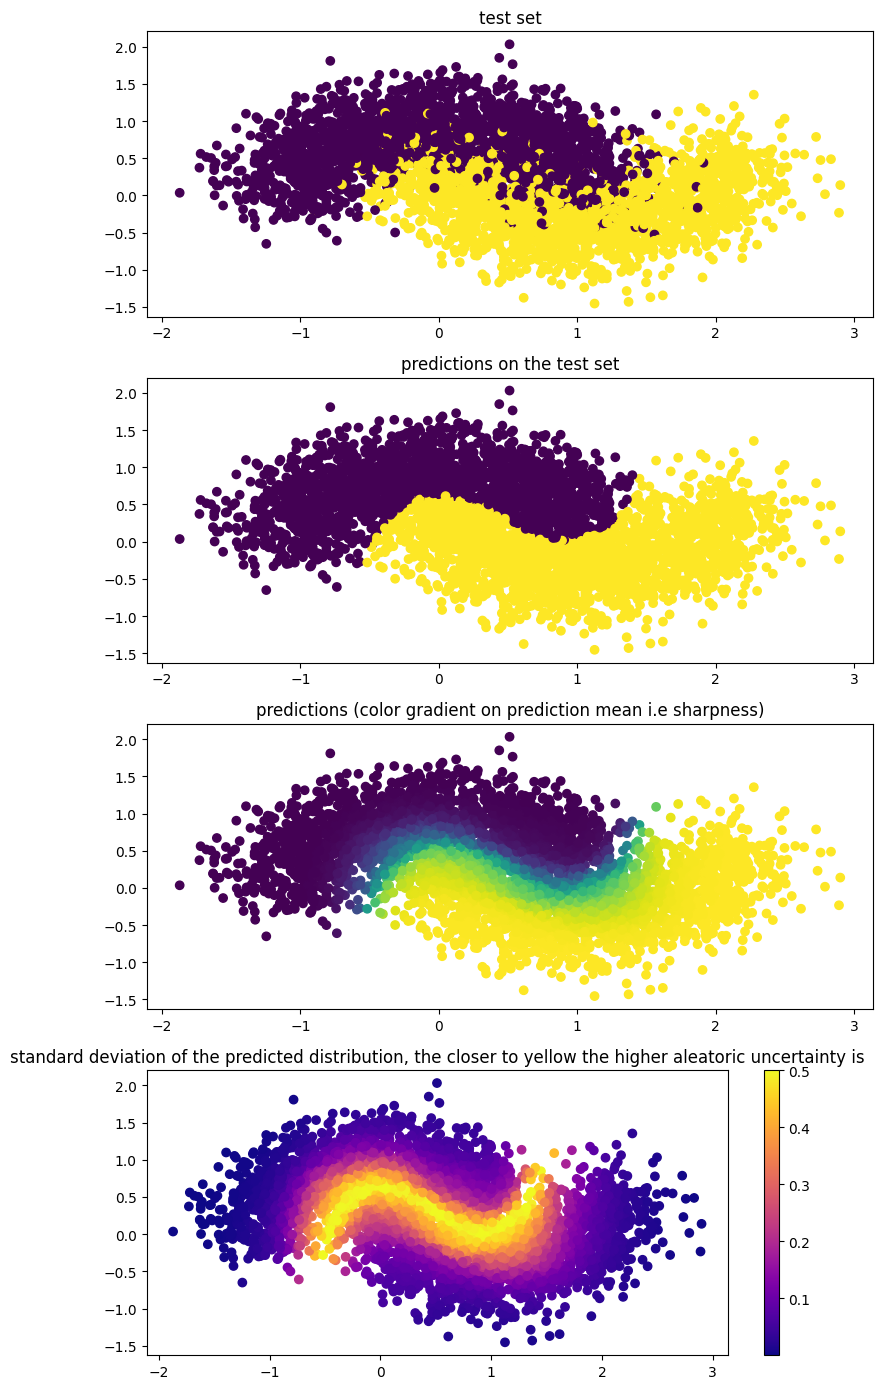

In [44]:
pred_distribution = aleatoric_model(X_test)
pred_mean = pred_distribution.mean().numpy()
pred_stdv = pred_distribution.stddev().numpy()

print('accuracy : ', accuracy_score(y_test, pred_mean.round()))

fig, axs = plt.subplots(4, 1, figsize=(8,14))
axs[0].scatter(X_test[:,0], X_test[:,1], c=y_test)
axs[0].set_title('test set')
axs[1].scatter(X_test[:,0], X_test[:,1], c=pred_mean.round())
axs[1].set_title('predictions on the test set')
axs[2].scatter(X_test[:,0], X_test[:,1], c=pred_mean)
axs[2].set_title('predictions (color gradient on prediction mean i.e sharpness)')
points2 = axs[3].scatter(X_test[:,0], X_test[:,1], c=pred_stdv, cmap='plasma')
axs[3].set_title('standard deviation of the predicted distribution, the closer to yellow the higher aleatoric uncertainty is')

fig.colorbar(points2)

plt.tight_layout()

* ### Epistemic uncertainty (aka systematic) : 
refers to uncertainty caused by a lack of knowledge, i.e the epistemic state of the agent

[Learning Confidence for Out-of-Distribution Detection in Neural Networks
](https://arxiv.org/pdf/1802.04865.pdf)

In [6]:
def create_epistemic_model(prior, posterior):
  inputs = keras.Input(shape=(X_train.shape[1],))

  x = tfp.layers.DenseVariational(units=100, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(inputs)
  
  x = tfp.layers.DenseVariational(units=200, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(x)
    
  x = tfp.layers.DenseVariational(units=100, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(x)
                        
  outputs = tfp.layers.DenseVariational(units=1, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='sigmoid')(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name='epistemic_BNN')

  opt = keras.optimizers.Adam(learning_rate=0.001)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=opt, metrics=['Accuracy'])
  model.summary()

  return model

In [44]:
def normal_prior(kernel_size, bias_size, dtype=None): 
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
    [
          tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=tf.zeros(n),
                       scale=2*tf.ones(n)), 
          reinterpreted_batch_ndims=1)),
    ])
    return prior_model

In [7]:
def multivariate_normal_prior(kernel_size, bias_size, dtype=None): 
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfd.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

In [57]:
def laplace_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size # num of params
    return Sequential([
       tfp.layers.DistributionLambda(
           lambda t: tfd.Independent(tfd.Laplace(loc = tf.zeros(n), 
                                                 scale=tf.ones(n)),
                                     reinterpreted_batch_ndims=1))               
  ])

In [8]:
def posterior(kernel_size, bias_size, dtype=None): 
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    
    return posterior_model

In [41]:
def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.IndependentNormal.params_size(n), dtype=dtype
            ),
            tfp.layers.IndependentNormal(n),
        ]
    )
    
  return posterior_model

In [59]:
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=tf.nn.softplus(t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

In [9]:
epistemic_model = create_epistemic_model(multivariate_normal_prior, posterior)
epistemic_model.fit(X_train, y_train, batch_size=32, verbose=0, epochs=20) 

2024-02-10 18:31:40.965406: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 816201200 exceeds 10% of free system memory.
2024-02-10 18:31:41.407028: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 808140600 exceeds 10% of free system memory.


NameError: name 'AUC' is not defined

Epoch 185/200
150/150 [==============================] - 0s 2ms/step - loss: 1.2179 - precision: 0.7993 - recall: 0.5395 - AUC: 0.7338 - val_loss: 1.1789 - val_precision: 0.7569 - val_recall: 0.5505 - val_AUC: 0.7327
Epoch 186/200
150/150 [==============================] - 0s 2ms/step - loss: 1.2135 - precision: 0.7778 - recall: 0.5224 - AUC: 0.7151 - val_loss: 1.2508 - val_precision: 0.7814 - val_recall: 0.5657 - val_AUC: 0.7296
Epoch 187/200
150/150 [==============================] - 0s 2ms/step - loss: 1.1596 - precision: 0.8184 - recall: 0.5470 - AUC: 0.7486 - val_loss: 1.1374 - val_precision: 0.8658 - val_recall: 0.5539 - val_AUC: 0.7589
Epoch 188/200
150/150 [==============================] - 0s 2ms/step - loss: 1.2241 - precision: 0.7753 - recall: 0.5565 - AUC: 0.7170 - val_loss: 1.1888 - val_precision: 0.7807 - val_recall: 0.5993 - val_AUC: 0.7658
Epoch 189/200
150/150 [==============================] - 0s 2ms/step - loss: 1.1574 - precision: 0.7874 - recall: 0.5756 - AUC: 0.75

In [43]:
epistemic_model = create_epistemic_model(normal_prior, posterior)
epistemic_model = train_model(X_train, X_test, y_train, y_test, epistemic_model, epochs=500, verbose=1)
pred_mean, pred_stdv = infer(X_test, y_test, epistemic_model, 10) # normal normal

AUC :  0.9136608105254971


In [55]:
epistemic_model = create_epistemic_model(normal_prior, posterior)
epistemic_model = train_model(X_train, X_test, y_train, y_test, epistemic_model, epochs=500, verbose=1)
pred_mean, pred_stdv = infer(X_test, y_test, epistemic_model, 10) # normal wider scale normal

Model: "epistemic_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_variational_33 (Dense  (None, 100)              600       
 Variational)                                                    
                                                                 
 dense_variational_34 (Dense  (None, 100)              20200     
 Variational)                                                    
                                                                 
 dense_variational_35 (Dense  (None, 1)                202       
 Variational)                                                    
                                                                 
Total params: 21,002
Trainable params: 21,002
Non-trainable params: 0
_________________________________________________

Epoch 71/500
150/150 [==============================] - 0s 2ms/step - loss: 2.1411 - precision: 0.5185 - recall: 0.4659 - AUC: 0.5202 - val_loss: 2.0847 - val_precision: 0.5789 - val_recall: 0.5438 - val_AUC: 0.6000
Epoch 72/500
150/150 [==============================] - 0s 2ms/step - loss: 2.1269 - precision: 0.4977 - recall: 0.4522 - AUC: 0.5034 - val_loss: 2.1628 - val_precision: 0.4561 - val_recall: 0.4108 - val_AUC: 0.4598
Epoch 73/500
150/150 [==============================] - 0s 2ms/step - loss: 2.1117 - precision: 0.5116 - recall: 0.4759 - AUC: 0.5116 - val_loss: 2.1120 - val_precision: 0.4762 - val_recall: 0.4714 - val_AUC: 0.4885
Epoch 74/500
150/150 [==============================] - 0s 2ms/step - loss: 2.1180 - precision: 0.4949 - recall: 0.4040 - AUC: 0.4925 - val_loss: 2.1205 - val_precision: 0.4961 - val_recall: 0.4327 - val_AUC: 0.4843
Epoch 75/500
150/150 [==============================] - 0s 2ms/step - loss: 2.1229 - precision: 0.5277 - recall: 0.4830 - AUC: 0.5182 - 

Epoch 109/500
150/150 [==============================] - 0s 2ms/step - loss: 1.8275 - precision: 0.5206 - recall: 0.3620 - AUC: 0.5001 - val_loss: 1.8317 - val_precision: 0.4763 - val_recall: 0.3047 - val_AUC: 0.4713
Epoch 110/500
150/150 [==============================] - 0s 2ms/step - loss: 1.7490 - precision: 0.5310 - recall: 0.3101 - AUC: 0.5096 - val_loss: 1.7898 - val_precision: 0.5340 - val_recall: 0.4360 - val_AUC: 0.5137
Epoch 111/500
150/150 [==============================] - 0s 2ms/step - loss: 1.7652 - precision: 0.5326 - recall: 0.3325 - AUC: 0.5188 - val_loss: 1.7856 - val_precision: 0.4950 - val_recall: 0.2525 - val_AUC: 0.4459
Epoch 112/500
150/150 [==============================] - 0s 2ms/step - loss: 1.7771 - precision: 0.5280 - recall: 0.3138 - AUC: 0.5053 - val_loss: 1.7417 - val_precision: 0.5297 - val_recall: 0.3451 - val_AUC: 0.5021
Epoch 113/500
150/150 [==============================] - 0s 2ms/step - loss: 1.7471 - precision: 0.5527 - recall: 0.3728 - AUC: 0.53

Epoch 147/500
150/150 [==============================] - 0s 2ms/step - loss: 1.4579 - precision: 0.6895 - recall: 0.3055 - AUC: 0.5560 - val_loss: 1.4346 - val_precision: 0.7137 - val_recall: 0.3064 - val_AUC: 0.6024
Epoch 148/500
150/150 [==============================] - 0s 2ms/step - loss: 1.4655 - precision: 0.6714 - recall: 0.2930 - AUC: 0.5604 - val_loss: 1.4512 - val_precision: 0.7095 - val_recall: 0.2879 - val_AUC: 0.5496
Epoch 149/500
150/150 [==============================] - 0s 2ms/step - loss: 1.4859 - precision: 0.6378 - recall: 0.2847 - AUC: 0.5574 - val_loss: 1.4491 - val_precision: 0.6730 - val_recall: 0.2980 - val_AUC: 0.5405
Epoch 150/500
150/150 [==============================] - 0s 2ms/step - loss: 1.4636 - precision: 0.6720 - recall: 0.2801 - AUC: 0.5433 - val_loss: 1.4395 - val_precision: 0.6486 - val_recall: 0.2828 - val_AUC: 0.5346
Epoch 151/500
150/150 [==============================] - 0s 2ms/step - loss: 1.4666 - precision: 0.7011 - recall: 0.3130 - AUC: 0.58

Epoch 185/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1933 - precision: 0.8101 - recall: 0.5727 - AUC: 0.7470 - val_loss: 1.2312 - val_precision: 0.8069 - val_recall: 0.6330 - val_AUC: 0.7604
Epoch 186/500
150/150 [==============================] - 0s 2ms/step - loss: 1.2073 - precision: 0.7783 - recall: 0.5794 - AUC: 0.7540 - val_loss: 1.1673 - val_precision: 0.7918 - val_recall: 0.6532 - val_AUC: 0.7906
Epoch 187/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1765 - precision: 0.7843 - recall: 0.6076 - AUC: 0.7604 - val_loss: 1.1210 - val_precision: 0.8077 - val_recall: 0.5657 - val_AUC: 0.7857
Epoch 188/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1589 - precision: 0.8274 - recall: 0.5619 - AUC: 0.7650 - val_loss: 1.1318 - val_precision: 0.8128 - val_recall: 0.5337 - val_AUC: 0.7452
Epoch 189/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1656 - precision: 0.7994 - recall: 0.5931 - AUC: 0.76

Epoch 223/500
150/150 [==============================] - 0s 2ms/step - loss: 0.9804 - precision: 0.8638 - recall: 0.6459 - AUC: 0.8289 - val_loss: 0.9932 - val_precision: 0.8478 - val_recall: 0.6751 - val_AUC: 0.8356
Epoch 224/500
150/150 [==============================] - 0s 2ms/step - loss: 1.0141 - precision: 0.8475 - recall: 0.6608 - AUC: 0.8259 - val_loss: 0.9801 - val_precision: 0.8472 - val_recall: 0.6347 - val_AUC: 0.8160
Epoch 225/500
150/150 [==============================] - 0s 2ms/step - loss: 0.9906 - precision: 0.8560 - recall: 0.6471 - AUC: 0.8202 - val_loss: 0.9504 - val_precision: 0.8702 - val_recall: 0.6549 - val_AUC: 0.8506
Epoch 226/500
150/150 [==============================] - 0s 2ms/step - loss: 1.0151 - precision: 0.8383 - recall: 0.6613 - AUC: 0.8221 - val_loss: 0.9838 - val_precision: 0.8670 - val_recall: 0.6364 - val_AUC: 0.8483
Epoch 227/500
150/150 [==============================] - 0s 2ms/step - loss: 1.0207 - precision: 0.8257 - recall: 0.6496 - AUC: 0.81

Epoch 261/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8566 - precision: 0.8846 - recall: 0.6725 - AUC: 0.8451 - val_loss: 0.8841 - val_precision: 0.8357 - val_recall: 0.6936 - val_AUC: 0.8333
Epoch 262/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8973 - precision: 0.8536 - recall: 0.6787 - AUC: 0.8476 - val_loss: 0.8877 - val_precision: 0.8474 - val_recall: 0.7104 - val_AUC: 0.8544
Epoch 263/500
150/150 [==============================] - 0s 2ms/step - loss: 0.9063 - precision: 0.8436 - recall: 0.6791 - AUC: 0.8282 - val_loss: 0.8761 - val_precision: 0.8588 - val_recall: 0.7576 - val_AUC: 0.8663
Epoch 264/500
150/150 [==============================] - 0s 2ms/step - loss: 0.9003 - precision: 0.8676 - recall: 0.6783 - AUC: 0.8509 - val_loss: 0.8946 - val_precision: 0.8761 - val_recall: 0.6785 - val_AUC: 0.8359
Epoch 265/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8634 - precision: 0.8747 - recall: 0.6850 - AUC: 0.84

Epoch 299/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7979 - precision: 0.8664 - recall: 0.7032 - AUC: 0.8511 - val_loss: 0.9149 - val_precision: 0.8159 - val_recall: 0.7239 - val_AUC: 0.8323
Epoch 300/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8157 - precision: 0.8613 - recall: 0.6891 - AUC: 0.8510 - val_loss: 0.7946 - val_precision: 0.8623 - val_recall: 0.7273 - val_AUC: 0.8615
Epoch 301/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8008 - precision: 0.8582 - recall: 0.7170 - AUC: 0.8587 - val_loss: 0.8262 - val_precision: 0.8401 - val_recall: 0.6987 - val_AUC: 0.8448
Epoch 302/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8069 - precision: 0.8683 - recall: 0.7178 - AUC: 0.8621 - val_loss: 0.7786 - val_precision: 0.8606 - val_recall: 0.7172 - val_AUC: 0.8731
Epoch 303/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7857 - precision: 0.8811 - recall: 0.6870 - AUC: 0.85

Epoch 337/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7575 - precision: 0.8608 - recall: 0.7224 - AUC: 0.8581 - val_loss: 0.7459 - val_precision: 0.8675 - val_recall: 0.7273 - val_AUC: 0.8655
Epoch 338/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7370 - precision: 0.8512 - recall: 0.7373 - AUC: 0.8724 - val_loss: 0.7871 - val_precision: 0.8516 - val_recall: 0.7441 - val_AUC: 0.8516
Epoch 339/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7382 - precision: 0.8549 - recall: 0.7369 - AUC: 0.8669 - val_loss: 0.7758 - val_precision: 0.8475 - val_recall: 0.7205 - val_AUC: 0.8551
Epoch 340/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7530 - precision: 0.8541 - recall: 0.7564 - AUC: 0.8646 - val_loss: 0.7419 - val_precision: 0.8497 - val_recall: 0.7138 - val_AUC: 0.8554
Epoch 341/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7143 - precision: 0.8873 - recall: 0.7361 - AUC: 0.87

Epoch 375/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7230 - precision: 0.8469 - recall: 0.7564 - AUC: 0.8665 - val_loss: 0.6914 - val_precision: 0.8556 - val_recall: 0.7778 - val_AUC: 0.8745
Epoch 376/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7228 - precision: 0.8481 - recall: 0.7544 - AUC: 0.8657 - val_loss: 0.7070 - val_precision: 0.8714 - val_recall: 0.7643 - val_AUC: 0.8651
Epoch 377/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7078 - precision: 0.8584 - recall: 0.7585 - AUC: 0.8700 - val_loss: 0.6821 - val_precision: 0.8850 - val_recall: 0.7256 - val_AUC: 0.8718
Epoch 378/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7091 - precision: 0.8437 - recall: 0.7539 - AUC: 0.8646 - val_loss: 0.7241 - val_precision: 0.8479 - val_recall: 0.7508 - val_AUC: 0.8623
Epoch 379/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7065 - precision: 0.8655 - recall: 0.7515 - AUC: 0.87

Epoch 413/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6839 - precision: 0.8535 - recall: 0.7606 - AUC: 0.8754 - val_loss: 0.6665 - val_precision: 0.8521 - val_recall: 0.7761 - val_AUC: 0.8887
Epoch 414/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6795 - precision: 0.8494 - recall: 0.7760 - AUC: 0.8751 - val_loss: 0.6772 - val_precision: 0.8733 - val_recall: 0.7542 - val_AUC: 0.8766
Epoch 415/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6747 - precision: 0.8632 - recall: 0.7710 - AUC: 0.8770 - val_loss: 0.6637 - val_precision: 0.8577 - val_recall: 0.7912 - val_AUC: 0.8805
Epoch 416/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6828 - precision: 0.8375 - recall: 0.7714 - AUC: 0.8741 - val_loss: 0.6659 - val_precision: 0.8809 - val_recall: 0.7845 - val_AUC: 0.8904
Epoch 417/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6832 - precision: 0.8652 - recall: 0.7606 - AUC: 0.87

Epoch 451/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6433 - precision: 0.8814 - recall: 0.7814 - AUC: 0.8913 - val_loss: 0.6597 - val_precision: 0.8273 - val_recall: 0.7744 - val_AUC: 0.8854
Epoch 452/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6546 - precision: 0.8611 - recall: 0.7781 - AUC: 0.8873 - val_loss: 0.6851 - val_precision: 0.8552 - val_recall: 0.7559 - val_AUC: 0.8834
Epoch 453/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6734 - precision: 0.8496 - recall: 0.7656 - AUC: 0.8790 - val_loss: 0.6470 - val_precision: 0.8760 - val_recall: 0.7727 - val_AUC: 0.8949
Epoch 454/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6372 - precision: 0.8610 - recall: 0.7876 - AUC: 0.8906 - val_loss: 0.6722 - val_precision: 0.8245 - val_recall: 0.7828 - val_AUC: 0.8840
Epoch 455/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6585 - precision: 0.8545 - recall: 0.7735 - AUC: 0.88

Epoch 489/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6276 - precision: 0.8598 - recall: 0.8005 - AUC: 0.8956 - val_loss: 0.6296 - val_precision: 0.8373 - val_recall: 0.8232 - val_AUC: 0.9020
Epoch 490/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6370 - precision: 0.8473 - recall: 0.7959 - AUC: 0.8943 - val_loss: 0.6348 - val_precision: 0.8624 - val_recall: 0.7912 - val_AUC: 0.8930
Epoch 491/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6488 - precision: 0.8560 - recall: 0.7860 - AUC: 0.8876 - val_loss: 0.6179 - val_precision: 0.8725 - val_recall: 0.7946 - val_AUC: 0.9008
Epoch 492/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6392 - precision: 0.8621 - recall: 0.7926 - AUC: 0.8937 - val_loss: 0.6218 - val_precision: 0.8455 - val_recall: 0.8199 - val_AUC: 0.9015
Epoch 493/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6287 - precision: 0.8585 - recall: 0.7997 - AUC: 0.89

In [54]:
epistemic_model = create_epistemic_model(multivariate_normal_prior, posterior)
epistemic_model = train_model(X_train, X_test, y_train, y_test, epistemic_model, epochs=500, verbose=1)
pred_mean, pred_stdv = infer(X_test, y_test, epistemic_model, 10) # multivariate normal

Model: "epistemic_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_variational_30 (Dense  (None, 100)              600       
 Variational)                                                    
                                                                 
 dense_variational_31 (Dense  (None, 100)              20200     
 Variational)                                                    
                                                                 
 dense_variational_32 (Dense  (None, 1)                202       
 Variational)                                                    
                                                                 
Total params: 21,002
Trainable params: 21,002
Non-trainable params: 0
_________________________________________________

Epoch 71/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1376 - precision: 0.4960 - recall: 0.4406 - AUC: 0.4792 - val_loss: 1.1492 - val_precision: 0.4823 - val_recall: 0.5034 - val_AUC: 0.4702
Epoch 72/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1103 - precision: 0.5173 - recall: 0.4909 - AUC: 0.5268 - val_loss: 1.0979 - val_precision: 0.5107 - val_recall: 0.4007 - val_AUC: 0.5162
Epoch 73/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1073 - precision: 0.5086 - recall: 0.4680 - AUC: 0.5058 - val_loss: 1.1327 - val_precision: 0.4842 - val_recall: 0.3872 - val_AUC: 0.4741
Epoch 74/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1252 - precision: 0.4866 - recall: 0.4667 - AUC: 0.4752 - val_loss: 1.1252 - val_precision: 0.4983 - val_recall: 0.4815 - val_AUC: 0.4991
Epoch 75/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1177 - precision: 0.5330 - recall: 0.4460 - AUC: 0.5326 - 

Epoch 109/500
150/150 [==============================] - 0s 2ms/step - loss: 1.0197 - precision: 0.5654 - recall: 0.3811 - AUC: 0.5465 - val_loss: 1.0171 - val_precision: 0.6111 - val_recall: 0.3889 - val_AUC: 0.5754
Epoch 110/500
150/150 [==============================] - 0s 2ms/step - loss: 1.0031 - precision: 0.5910 - recall: 0.3603 - AUC: 0.5417 - val_loss: 0.9442 - val_precision: 0.6473 - val_recall: 0.4697 - val_AUC: 0.6145
Epoch 111/500
150/150 [==============================] - 0s 2ms/step - loss: 0.9907 - precision: 0.6224 - recall: 0.3878 - AUC: 0.5516 - val_loss: 1.0009 - val_precision: 0.5906 - val_recall: 0.4226 - val_AUC: 0.5498
Epoch 112/500
150/150 [==============================] - 0s 2ms/step - loss: 1.0226 - precision: 0.5466 - recall: 0.3317 - AUC: 0.5114 - val_loss: 1.0135 - val_precision: 0.6175 - val_recall: 0.3805 - val_AUC: 0.5648
Epoch 113/500
150/150 [==============================] - 0s 2ms/step - loss: 0.9853 - precision: 0.6095 - recall: 0.3483 - AUC: 0.55

Epoch 147/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8640 - precision: 0.7152 - recall: 0.5553 - AUC: 0.7058 - val_loss: 0.8185 - val_precision: 0.8000 - val_recall: 0.6734 - val_AUC: 0.7611
Epoch 148/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8914 - precision: 0.7204 - recall: 0.5536 - AUC: 0.7032 - val_loss: 0.8436 - val_precision: 0.7253 - val_recall: 0.5556 - val_AUC: 0.7241
Epoch 149/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8691 - precision: 0.7220 - recall: 0.5528 - AUC: 0.7098 - val_loss: 0.8918 - val_precision: 0.7299 - val_recall: 0.5185 - val_AUC: 0.7095
Epoch 150/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8421 - precision: 0.7700 - recall: 0.5470 - AUC: 0.7292 - val_loss: 0.8379 - val_precision: 0.7966 - val_recall: 0.5471 - val_AUC: 0.7345
Epoch 151/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8937 - precision: 0.7421 - recall: 0.5694 - AUC: 0.71

Epoch 185/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7261 - precision: 0.8432 - recall: 0.7041 - AUC: 0.8419 - val_loss: 0.6879 - val_precision: 0.8375 - val_recall: 0.7374 - val_AUC: 0.8562
Epoch 186/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6996 - precision: 0.8654 - recall: 0.6812 - AUC: 0.8504 - val_loss: 0.7194 - val_precision: 0.8245 - val_recall: 0.7357 - val_AUC: 0.8545
Epoch 187/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7240 - precision: 0.8439 - recall: 0.6966 - AUC: 0.8429 - val_loss: 0.7326 - val_precision: 0.8728 - val_recall: 0.6700 - val_AUC: 0.8464
Epoch 188/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7202 - precision: 0.8493 - recall: 0.7053 - AUC: 0.8476 - val_loss: 0.7136 - val_precision: 0.8357 - val_recall: 0.6936 - val_AUC: 0.8416
Epoch 189/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7094 - precision: 0.8369 - recall: 0.6783 - AUC: 0.84

Epoch 223/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6816 - precision: 0.8488 - recall: 0.7161 - AUC: 0.8492 - val_loss: 0.6529 - val_precision: 0.8311 - val_recall: 0.7458 - val_AUC: 0.8655
Epoch 224/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6613 - precision: 0.8559 - recall: 0.7012 - AUC: 0.8562 - val_loss: 0.6281 - val_precision: 0.8372 - val_recall: 0.7357 - val_AUC: 0.8743
Epoch 225/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6592 - precision: 0.8623 - recall: 0.7207 - AUC: 0.8633 - val_loss: 0.6669 - val_precision: 0.8366 - val_recall: 0.7239 - val_AUC: 0.8486
Epoch 226/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6402 - precision: 0.8746 - recall: 0.7161 - AUC: 0.8699 - val_loss: 0.6606 - val_precision: 0.8391 - val_recall: 0.7374 - val_AUC: 0.8687
Epoch 227/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6574 - precision: 0.8605 - recall: 0.7078 - AUC: 0.86

Epoch 261/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6195 - precision: 0.8638 - recall: 0.7406 - AUC: 0.8726 - val_loss: 0.6223 - val_precision: 0.8541 - val_recall: 0.7391 - val_AUC: 0.8729
Epoch 262/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6255 - precision: 0.8585 - recall: 0.7490 - AUC: 0.8724 - val_loss: 0.6025 - val_precision: 0.8487 - val_recall: 0.7744 - val_AUC: 0.8796
Epoch 263/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6128 - precision: 0.8630 - recall: 0.7465 - AUC: 0.8745 - val_loss: 0.6761 - val_precision: 0.8416 - val_recall: 0.7424 - val_AUC: 0.8606
Epoch 264/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6462 - precision: 0.8655 - recall: 0.7303 - AUC: 0.8626 - val_loss: 0.5958 - val_precision: 0.8658 - val_recall: 0.7492 - val_AUC: 0.8835
Epoch 265/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6096 - precision: 0.8645 - recall: 0.7348 - AUC: 0.87

Epoch 299/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5961 - precision: 0.8607 - recall: 0.7835 - AUC: 0.8836 - val_loss: 0.5996 - val_precision: 0.8313 - val_recall: 0.8047 - val_AUC: 0.8850
Epoch 300/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5907 - precision: 0.8707 - recall: 0.7614 - AUC: 0.8862 - val_loss: 0.5776 - val_precision: 0.8733 - val_recall: 0.7660 - val_AUC: 0.8886
Epoch 301/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5867 - precision: 0.8667 - recall: 0.7839 - AUC: 0.8857 - val_loss: 0.6393 - val_precision: 0.8383 - val_recall: 0.7508 - val_AUC: 0.8636
Epoch 302/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5918 - precision: 0.8679 - recall: 0.7702 - AUC: 0.8848 - val_loss: 0.5957 - val_precision: 0.8579 - val_recall: 0.7929 - val_AUC: 0.8895
Epoch 303/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5816 - precision: 0.8701 - recall: 0.7631 - AUC: 0.88

Epoch 337/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5732 - precision: 0.8621 - recall: 0.7922 - AUC: 0.8928 - val_loss: 0.5704 - val_precision: 0.8614 - val_recall: 0.7744 - val_AUC: 0.8911
Epoch 338/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5827 - precision: 0.8543 - recall: 0.7872 - AUC: 0.8869 - val_loss: 0.5894 - val_precision: 0.8388 - val_recall: 0.7795 - val_AUC: 0.8859
Epoch 339/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5893 - precision: 0.8553 - recall: 0.7643 - AUC: 0.8834 - val_loss: 0.5955 - val_precision: 0.8063 - val_recall: 0.8199 - val_AUC: 0.8798
Epoch 340/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5683 - precision: 0.8645 - recall: 0.7926 - AUC: 0.8968 - val_loss: 0.6091 - val_precision: 0.8399 - val_recall: 0.7862 - val_AUC: 0.8728
Epoch 341/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5724 - precision: 0.8611 - recall: 0.7830 - AUC: 0.88

Epoch 375/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5094 - precision: 0.8605 - recall: 0.8259 - AUC: 0.9200 - val_loss: 0.4866 - val_precision: 0.8654 - val_recall: 0.8552 - val_AUC: 0.9285
Epoch 376/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5040 - precision: 0.8567 - recall: 0.8271 - AUC: 0.9230 - val_loss: 0.4849 - val_precision: 0.8522 - val_recall: 0.8636 - val_AUC: 0.9297
Epoch 377/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5100 - precision: 0.8605 - recall: 0.8308 - AUC: 0.9199 - val_loss: 0.4971 - val_precision: 0.8339 - val_recall: 0.8535 - val_AUC: 0.9237
Epoch 378/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5182 - precision: 0.8458 - recall: 0.8250 - AUC: 0.9170 - val_loss: 0.5022 - val_precision: 0.8549 - val_recall: 0.8333 - val_AUC: 0.9216
Epoch 379/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5023 - precision: 0.8552 - recall: 0.8246 - AUC: 0.92

Epoch 413/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4477 - precision: 0.8612 - recall: 0.8791 - AUC: 0.9403 - val_loss: 0.4441 - val_precision: 0.8630 - val_recall: 0.8485 - val_AUC: 0.9414
Epoch 414/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4547 - precision: 0.8697 - recall: 0.8545 - AUC: 0.9379 - val_loss: 0.4682 - val_precision: 0.8624 - val_recall: 0.8333 - val_AUC: 0.9307
Epoch 415/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4653 - precision: 0.8529 - recall: 0.8483 - AUC: 0.9336 - val_loss: 0.4413 - val_precision: 0.8527 - val_recall: 0.8771 - val_AUC: 0.9423
Epoch 416/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4600 - precision: 0.8532 - recall: 0.8766 - AUC: 0.9364 - val_loss: 0.4687 - val_precision: 0.8444 - val_recall: 0.8586 - val_AUC: 0.9313
Epoch 417/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4528 - precision: 0.8748 - recall: 0.8512 - AUC: 0.93

Epoch 451/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4327 - precision: 0.8651 - recall: 0.8745 - AUC: 0.9448 - val_loss: 0.4110 - val_precision: 0.8789 - val_recall: 0.8923 - val_AUC: 0.9504
Epoch 452/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4278 - precision: 0.8725 - recall: 0.8849 - AUC: 0.9470 - val_loss: 0.4029 - val_precision: 0.8756 - val_recall: 0.8889 - val_AUC: 0.9534
Epoch 453/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4237 - precision: 0.8820 - recall: 0.8761 - AUC: 0.9479 - val_loss: 0.4118 - val_precision: 0.8599 - val_recall: 0.8889 - val_AUC: 0.9504
Epoch 454/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4306 - precision: 0.8693 - recall: 0.8766 - AUC: 0.9452 - val_loss: 0.4190 - val_precision: 0.8868 - val_recall: 0.8704 - val_AUC: 0.9499
Epoch 455/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4265 - precision: 0.8640 - recall: 0.8845 - AUC: 0.94

Epoch 489/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4024 - precision: 0.8904 - recall: 0.8944 - AUC: 0.9548 - val_loss: 0.3877 - val_precision: 0.9110 - val_recall: 0.8788 - val_AUC: 0.9597
Epoch 490/500
150/150 [==============================] - 0s 2ms/step - loss: 0.3908 - precision: 0.8935 - recall: 0.9027 - AUC: 0.9585 - val_loss: 0.3998 - val_precision: 0.8866 - val_recall: 0.8822 - val_AUC: 0.9581
Epoch 491/500
150/150 [==============================] - 0s 2ms/step - loss: 0.3926 - precision: 0.8928 - recall: 0.8894 - AUC: 0.9578 - val_loss: 0.3908 - val_precision: 0.8925 - val_recall: 0.8805 - val_AUC: 0.9601
Epoch 492/500
150/150 [==============================] - 0s 2ms/step - loss: 0.3998 - precision: 0.8896 - recall: 0.8978 - AUC: 0.9563 - val_loss: 0.3762 - val_precision: 0.9143 - val_recall: 0.8805 - val_AUC: 0.9640
Epoch 493/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4046 - precision: 0.8913 - recall: 0.8865 - AUC: 0.95

In [58]:
epistemic_model = create_epistemic_model(laplace_prior, posterior)
epistemic_model = train_model(X_train, X_test, y_train, y_test, epistemic_model, epochs=500, verbose=1)
pred_mean, pred_stdv = infer(X_test, y_test, epistemic_model, 10) # laplace normal

Model: "epistemic_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_variational_36 (Dense  (None, 100)              600       
 Variational)                                                    
                                                                 
 dense_variational_37 (Dense  (None, 100)              20200     
 Variational)                                                    
                                                                 
 dense_variational_38 (Dense  (None, 1)                202       
 Variational)                                                    
                                                                 
Total params: 21,002
Trainable params: 21,002
Non-trainable params: 0
_________________________________________________

Epoch 71/500
150/150 [==============================] - 0s 2ms/step - loss: 1.3296 - precision: 0.4868 - recall: 0.4522 - AUC: 0.4875 - val_loss: 1.3829 - val_precision: 0.5230 - val_recall: 0.3064 - val_AUC: 0.5017
Epoch 72/500
150/150 [==============================] - 0s 2ms/step - loss: 1.3354 - precision: 0.4976 - recall: 0.4393 - AUC: 0.5013 - val_loss: 1.3083 - val_precision: 0.4833 - val_recall: 0.4882 - val_AUC: 0.4958
Epoch 73/500
150/150 [==============================] - 0s 2ms/step - loss: 1.3360 - precision: 0.4841 - recall: 0.4306 - AUC: 0.4803 - val_loss: 1.2543 - val_precision: 0.5602 - val_recall: 0.5640 - val_AUC: 0.5668
Epoch 74/500
150/150 [==============================] - 0s 2ms/step - loss: 1.3025 - precision: 0.5179 - recall: 0.4988 - AUC: 0.5248 - val_loss: 1.2832 - val_precision: 0.5047 - val_recall: 0.4545 - val_AUC: 0.5176
Epoch 75/500
150/150 [==============================] - 0s 2ms/step - loss: 1.3283 - precision: 0.4956 - recall: 0.4414 - AUC: 0.4982 - 

Epoch 109/500
150/150 [==============================] - 0s 2ms/step - loss: 1.2323 - precision: 0.5285 - recall: 0.3899 - AUC: 0.5106 - val_loss: 1.1777 - val_precision: 0.5758 - val_recall: 0.3199 - val_AUC: 0.5495
Epoch 110/500
150/150 [==============================] - 0s 2ms/step - loss: 1.2466 - precision: 0.5284 - recall: 0.4177 - AUC: 0.5114 - val_loss: 1.2110 - val_precision: 0.4916 - val_recall: 0.2458 - val_AUC: 0.4627
Epoch 111/500
150/150 [==============================] - 0s 2ms/step - loss: 1.2058 - precision: 0.5765 - recall: 0.3383 - AUC: 0.5375 - val_loss: 1.2036 - val_precision: 0.5884 - val_recall: 0.3249 - val_AUC: 0.5533
Epoch 112/500
150/150 [==============================] - 0s 2ms/step - loss: 1.2038 - precision: 0.5619 - recall: 0.3263 - AUC: 0.5197 - val_loss: 1.2076 - val_precision: 0.5314 - val_recall: 0.3990 - val_AUC: 0.5270
Epoch 113/500
150/150 [==============================] - 0s 2ms/step - loss: 1.2026 - precision: 0.5768 - recall: 0.4044 - AUC: 0.53

Epoch 147/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1085 - precision: 0.6820 - recall: 0.5100 - AUC: 0.6508 - val_loss: 1.0770 - val_precision: 0.7297 - val_recall: 0.5135 - val_AUC: 0.6678
Epoch 148/500
150/150 [==============================] - 0s 2ms/step - loss: 1.0898 - precision: 0.7381 - recall: 0.5295 - AUC: 0.6890 - val_loss: 1.0816 - val_precision: 0.6867 - val_recall: 0.5572 - val_AUC: 0.6757
Epoch 149/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1111 - precision: 0.7097 - recall: 0.4909 - AUC: 0.6633 - val_loss: 1.1030 - val_precision: 0.7126 - val_recall: 0.4966 - val_AUC: 0.6750
Epoch 150/500
150/150 [==============================] - 0s 2ms/step - loss: 1.0748 - precision: 0.7189 - recall: 0.5208 - AUC: 0.6895 - val_loss: 1.0483 - val_precision: 0.7356 - val_recall: 0.4731 - val_AUC: 0.7248
Epoch 151/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1072 - precision: 0.6970 - recall: 0.5287 - AUC: 0.66

Epoch 185/500
150/150 [==============================] - 0s 2ms/step - loss: 0.9099 - precision: 0.8097 - recall: 0.6933 - AUC: 0.8362 - val_loss: 0.8516 - val_precision: 0.8712 - val_recall: 0.7172 - val_AUC: 0.8636
Epoch 186/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8824 - precision: 0.8542 - recall: 0.6696 - AUC: 0.8339 - val_loss: 0.8770 - val_precision: 0.8353 - val_recall: 0.7172 - val_AUC: 0.8525
Epoch 187/500
150/150 [==============================] - 0s 2ms/step - loss: 0.9070 - precision: 0.8382 - recall: 0.6866 - AUC: 0.8279 - val_loss: 0.9457 - val_precision: 0.8008 - val_recall: 0.7037 - val_AUC: 0.8230
Epoch 188/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8753 - precision: 0.8545 - recall: 0.6787 - AUC: 0.8512 - val_loss: 0.9183 - val_precision: 0.8246 - val_recall: 0.7121 - val_AUC: 0.8377
Epoch 189/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8889 - precision: 0.8638 - recall: 0.6750 - AUC: 0.84

Epoch 223/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8269 - precision: 0.8660 - recall: 0.7012 - AUC: 0.8582 - val_loss: 0.8058 - val_precision: 0.8458 - val_recall: 0.7205 - val_AUC: 0.8555
Epoch 224/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8146 - precision: 0.8644 - recall: 0.7182 - AUC: 0.8591 - val_loss: 0.7738 - val_precision: 0.8912 - val_recall: 0.7172 - val_AUC: 0.8742
Epoch 225/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8155 - precision: 0.8667 - recall: 0.7132 - AUC: 0.8645 - val_loss: 0.7858 - val_precision: 0.8814 - val_recall: 0.7256 - val_AUC: 0.8790
Epoch 226/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8150 - precision: 0.8668 - recall: 0.6953 - AUC: 0.8627 - val_loss: 0.8069 - val_precision: 0.8452 - val_recall: 0.7172 - val_AUC: 0.8652
Epoch 227/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8198 - precision: 0.8600 - recall: 0.7174 - AUC: 0.86

Epoch 261/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7683 - precision: 0.8467 - recall: 0.7436 - AUC: 0.8682 - val_loss: 0.7796 - val_precision: 0.8367 - val_recall: 0.7761 - val_AUC: 0.8724
Epoch 262/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7631 - precision: 0.8500 - recall: 0.7465 - AUC: 0.8693 - val_loss: 0.7787 - val_precision: 0.8214 - val_recall: 0.7121 - val_AUC: 0.8634
Epoch 263/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7637 - precision: 0.8611 - recall: 0.7444 - AUC: 0.8683 - val_loss: 0.7802 - val_precision: 0.8588 - val_recall: 0.7273 - val_AUC: 0.8593
Epoch 264/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7601 - precision: 0.8711 - recall: 0.7386 - AUC: 0.8696 - val_loss: 0.7873 - val_precision: 0.8244 - val_recall: 0.7508 - val_AUC: 0.8752
Epoch 265/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7827 - precision: 0.8488 - recall: 0.7398 - AUC: 0.86

Epoch 299/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7285 - precision: 0.8703 - recall: 0.7614 - AUC: 0.8780 - val_loss: 0.7033 - val_precision: 0.8579 - val_recall: 0.7727 - val_AUC: 0.8895
Epoch 300/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7263 - precision: 0.8567 - recall: 0.7581 - AUC: 0.8740 - val_loss: 0.7265 - val_precision: 0.8633 - val_recall: 0.7761 - val_AUC: 0.8850
Epoch 301/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7329 - precision: 0.8587 - recall: 0.7677 - AUC: 0.8766 - val_loss: 0.7238 - val_precision: 0.8483 - val_recall: 0.7626 - val_AUC: 0.8742
Epoch 302/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7382 - precision: 0.8617 - recall: 0.7510 - AUC: 0.8708 - val_loss: 0.7157 - val_precision: 0.8696 - val_recall: 0.7744 - val_AUC: 0.8882
Epoch 303/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7202 - precision: 0.8663 - recall: 0.7785 - AUC: 0.87

Epoch 337/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6882 - precision: 0.8659 - recall: 0.7889 - AUC: 0.8894 - val_loss: 0.7056 - val_precision: 0.8455 - val_recall: 0.7828 - val_AUC: 0.8847
Epoch 338/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6780 - precision: 0.8727 - recall: 0.7976 - AUC: 0.8978 - val_loss: 0.6949 - val_precision: 0.8477 - val_recall: 0.7963 - val_AUC: 0.8893
Epoch 339/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6866 - precision: 0.8644 - recall: 0.7972 - AUC: 0.8925 - val_loss: 0.6692 - val_precision: 0.8825 - val_recall: 0.7963 - val_AUC: 0.8993
Epoch 340/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6685 - precision: 0.8718 - recall: 0.7943 - AUC: 0.9002 - val_loss: 0.6654 - val_precision: 0.8669 - val_recall: 0.8114 - val_AUC: 0.9036
Epoch 341/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6845 - precision: 0.8608 - recall: 0.7868 - AUC: 0.89

Epoch 375/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6353 - precision: 0.8701 - recall: 0.8321 - AUC: 0.9172 - val_loss: 0.6287 - val_precision: 0.8798 - val_recall: 0.7761 - val_AUC: 0.9200
Epoch 376/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6311 - precision: 0.8809 - recall: 0.8146 - AUC: 0.9202 - val_loss: 0.6126 - val_precision: 0.8711 - val_recall: 0.8418 - val_AUC: 0.9289
Epoch 377/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6148 - precision: 0.8821 - recall: 0.8337 - AUC: 0.9242 - val_loss: 0.5973 - val_precision: 0.8875 - val_recall: 0.8636 - val_AUC: 0.9328
Epoch 378/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6254 - precision: 0.8635 - recall: 0.8283 - AUC: 0.9223 - val_loss: 0.6035 - val_precision: 0.8603 - val_recall: 0.8401 - val_AUC: 0.9295
Epoch 379/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6123 - precision: 0.8801 - recall: 0.8454 - AUC: 0.92

Epoch 413/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5429 - precision: 0.8882 - recall: 0.8815 - AUC: 0.9487 - val_loss: 0.5334 - val_precision: 0.8850 - val_recall: 0.8939 - val_AUC: 0.9514
Epoch 414/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5284 - precision: 0.8945 - recall: 0.8878 - AUC: 0.9530 - val_loss: 0.5306 - val_precision: 0.8848 - val_recall: 0.8923 - val_AUC: 0.9548
Epoch 415/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5443 - precision: 0.8852 - recall: 0.8811 - AUC: 0.9486 - val_loss: 0.5262 - val_precision: 0.8804 - val_recall: 0.8923 - val_AUC: 0.9539
Epoch 416/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5367 - precision: 0.8995 - recall: 0.8745 - AUC: 0.9507 - val_loss: 0.5511 - val_precision: 0.8752 - val_recall: 0.8855 - val_AUC: 0.9440
Epoch 417/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5405 - precision: 0.8912 - recall: 0.8786 - AUC: 0.94

Epoch 451/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5026 - precision: 0.8989 - recall: 0.8903 - AUC: 0.9590 - val_loss: 0.5171 - val_precision: 0.9047 - val_recall: 0.8788 - val_AUC: 0.9554
Epoch 452/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5178 - precision: 0.8996 - recall: 0.8865 - AUC: 0.9552 - val_loss: 0.5198 - val_precision: 0.9054 - val_recall: 0.8704 - val_AUC: 0.9544
Epoch 453/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5087 - precision: 0.9014 - recall: 0.8820 - AUC: 0.9568 - val_loss: 0.5076 - val_precision: 0.8978 - val_recall: 0.9024 - val_AUC: 0.9577
Epoch 454/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5204 - precision: 0.8940 - recall: 0.8907 - AUC: 0.9545 - val_loss: 0.4999 - val_precision: 0.8963 - val_recall: 0.9024 - val_AUC: 0.9610
Epoch 455/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5044 - precision: 0.8990 - recall: 0.8953 - AUC: 0.95

Epoch 489/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5077 - precision: 0.9025 - recall: 0.8924 - AUC: 0.9568 - val_loss: 0.4883 - val_precision: 0.8939 - val_recall: 0.9074 - val_AUC: 0.9630
Epoch 490/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5024 - precision: 0.8985 - recall: 0.8973 - AUC: 0.9579 - val_loss: 0.4818 - val_precision: 0.8917 - val_recall: 0.9007 - val_AUC: 0.9641
Epoch 491/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4981 - precision: 0.9017 - recall: 0.8957 - AUC: 0.9594 - val_loss: 0.4820 - val_precision: 0.9028 - val_recall: 0.9074 - val_AUC: 0.9643
Epoch 492/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5109 - precision: 0.8888 - recall: 0.8965 - AUC: 0.9554 - val_loss: 0.4879 - val_precision: 0.8889 - val_recall: 0.9024 - val_AUC: 0.9626
Epoch 493/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4956 - precision: 0.8993 - recall: 0.8982 - AUC: 0.96

In [60]:
epistemic_model = create_epistemic_model(laplace_prior, posterior)
epistemic_model = train_model(X_train, X_test, y_train, y_test, epistemic_model, epochs=500, verbose=1)
pred_mean, pred_stdv = infer(X_test, y_test, epistemic_model, 10) # laplace normal

Model: "epistemic_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_variational_39 (Dense  (None, 100)              600       
 Variational)                                                    
                                                                 
 dense_variational_40 (Dense  (None, 100)              20200     
 Variational)                                                    
                                                                 
 dense_variational_41 (Dense  (None, 1)                202       
 Variational)                                                    
                                                                 
Total params: 21,002
Trainable params: 21,002
Non-trainable params: 0
_________________________________________________

Epoch 71/500
150/150 [==============================] - 0s 2ms/step - loss: 1.3456 - precision: 0.5085 - recall: 0.4863 - AUC: 0.5113 - val_loss: 1.3442 - val_precision: 0.4889 - val_recall: 0.4444 - val_AUC: 0.4797
Epoch 72/500
150/150 [==============================] - 0s 2ms/step - loss: 1.3489 - precision: 0.4964 - recall: 0.4273 - AUC: 0.4704 - val_loss: 1.2645 - val_precision: 0.5588 - val_recall: 0.3838 - val_AUC: 0.5247
Epoch 73/500
150/150 [==============================] - 0s 2ms/step - loss: 1.3169 - precision: 0.5146 - recall: 0.5287 - AUC: 0.5155 - val_loss: 1.3685 - val_precision: 0.4340 - val_recall: 0.3434 - val_AUC: 0.4439
Epoch 74/500
150/150 [==============================] - 0s 2ms/step - loss: 1.3095 - precision: 0.5069 - recall: 0.4555 - AUC: 0.5111 - val_loss: 1.3536 - val_precision: 0.4444 - val_recall: 0.3906 - val_AUC: 0.4326
Epoch 75/500
150/150 [==============================] - 0s 2ms/step - loss: 1.3157 - precision: 0.4774 - recall: 0.3641 - AUC: 0.4817 - 

Epoch 109/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1900 - precision: 0.5809 - recall: 0.3433 - AUC: 0.5415 - val_loss: 1.2491 - val_precision: 0.5760 - val_recall: 0.4209 - val_AUC: 0.5577
Epoch 110/500
150/150 [==============================] - 0s 2ms/step - loss: 1.2218 - precision: 0.5429 - recall: 0.3263 - AUC: 0.5061 - val_loss: 1.1890 - val_precision: 0.5259 - val_recall: 0.4108 - val_AUC: 0.5136
Epoch 111/500
150/150 [==============================] - 0s 2ms/step - loss: 1.1812 - precision: 0.6047 - recall: 0.3948 - AUC: 0.5704 - val_loss: 1.2236 - val_precision: 0.6101 - val_recall: 0.3872 - val_AUC: 0.5586
Epoch 112/500
150/150 [==============================] - 0s 2ms/step - loss: 1.2218 - precision: 0.5355 - recall: 0.3167 - AUC: 0.4984 - val_loss: 1.2225 - val_precision: 0.5042 - val_recall: 0.2997 - val_AUC: 0.4996
Epoch 113/500
150/150 [==============================] - 0s 2ms/step - loss: 1.2160 - precision: 0.5915 - recall: 0.3304 - AUC: 0.52

Epoch 147/500
150/150 [==============================] - 0s 2ms/step - loss: 1.0824 - precision: 0.6914 - recall: 0.4992 - AUC: 0.6552 - val_loss: 1.0586 - val_precision: 0.6925 - val_recall: 0.5421 - val_AUC: 0.6641
Epoch 148/500
150/150 [==============================] - 0s 2ms/step - loss: 1.0666 - precision: 0.7099 - recall: 0.5258 - AUC: 0.6836 - val_loss: 1.0790 - val_precision: 0.6918 - val_recall: 0.5253 - val_AUC: 0.6956
Epoch 149/500
150/150 [==============================] - 0s 2ms/step - loss: 1.0778 - precision: 0.6921 - recall: 0.4942 - AUC: 0.6565 - val_loss: 1.1654 - val_precision: 0.6802 - val_recall: 0.5657 - val_AUC: 0.6764
Epoch 150/500
150/150 [==============================] - 0s 2ms/step - loss: 1.0422 - precision: 0.7373 - recall: 0.5856 - AUC: 0.7329 - val_loss: 1.0272 - val_precision: 0.7335 - val_recall: 0.6347 - val_AUC: 0.7496
Epoch 151/500
150/150 [==============================] - 0s 2ms/step - loss: 1.0720 - precision: 0.7229 - recall: 0.5183 - AUC: 0.68

Epoch 185/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8778 - precision: 0.8574 - recall: 0.6850 - AUC: 0.8476 - val_loss: 0.8695 - val_precision: 0.8485 - val_recall: 0.7071 - val_AUC: 0.8535
Epoch 186/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8838 - precision: 0.8510 - recall: 0.6858 - AUC: 0.8477 - val_loss: 0.8474 - val_precision: 0.8535 - val_recall: 0.7256 - val_AUC: 0.8604
Epoch 187/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8861 - precision: 0.8415 - recall: 0.6642 - AUC: 0.8400 - val_loss: 0.9197 - val_precision: 0.8441 - val_recall: 0.7020 - val_AUC: 0.8395
Epoch 188/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8852 - precision: 0.8329 - recall: 0.6941 - AUC: 0.8441 - val_loss: 0.8577 - val_precision: 0.8443 - val_recall: 0.7121 - val_AUC: 0.8583
Epoch 189/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8920 - precision: 0.8338 - recall: 0.6862 - AUC: 0.84

Epoch 223/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8240 - precision: 0.8503 - recall: 0.7199 - AUC: 0.8621 - val_loss: 0.8501 - val_precision: 0.8377 - val_recall: 0.7559 - val_AUC: 0.8665
Epoch 224/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7977 - precision: 0.8742 - recall: 0.7307 - AUC: 0.8732 - val_loss: 0.8111 - val_precision: 0.8261 - val_recall: 0.7357 - val_AUC: 0.8568
Epoch 225/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8305 - precision: 0.8503 - recall: 0.7153 - AUC: 0.8625 - val_loss: 0.8086 - val_precision: 0.8337 - val_recall: 0.7256 - val_AUC: 0.8847
Epoch 226/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8129 - precision: 0.8589 - recall: 0.7261 - AUC: 0.8620 - val_loss: 0.7849 - val_precision: 0.8467 - val_recall: 0.7441 - val_AUC: 0.8698
Epoch 227/500
150/150 [==============================] - 0s 2ms/step - loss: 0.8070 - precision: 0.8490 - recall: 0.7128 - AUC: 0.85

Epoch 261/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7653 - precision: 0.8523 - recall: 0.7677 - AUC: 0.8763 - val_loss: 0.7530 - val_precision: 0.8396 - val_recall: 0.7929 - val_AUC: 0.8903
Epoch 262/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7564 - precision: 0.8624 - recall: 0.7502 - AUC: 0.8762 - val_loss: 0.7718 - val_precision: 0.8346 - val_recall: 0.7391 - val_AUC: 0.8762
Epoch 263/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7622 - precision: 0.8531 - recall: 0.7461 - AUC: 0.8775 - val_loss: 0.7367 - val_precision: 0.8835 - val_recall: 0.7407 - val_AUC: 0.8866
Epoch 264/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7683 - precision: 0.8486 - recall: 0.7618 - AUC: 0.8700 - val_loss: 0.7739 - val_precision: 0.8169 - val_recall: 0.7660 - val_AUC: 0.8745
Epoch 265/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7660 - precision: 0.8509 - recall: 0.7494 - AUC: 0.86

Epoch 299/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7435 - precision: 0.8583 - recall: 0.7631 - AUC: 0.8742 - val_loss: 0.7501 - val_precision: 0.8480 - val_recall: 0.7323 - val_AUC: 0.8715
Epoch 300/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7360 - precision: 0.8606 - recall: 0.7618 - AUC: 0.8811 - val_loss: 0.7171 - val_precision: 0.8339 - val_recall: 0.7946 - val_AUC: 0.8845
Epoch 301/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7272 - precision: 0.8590 - recall: 0.7697 - AUC: 0.8814 - val_loss: 0.7400 - val_precision: 0.8539 - val_recall: 0.7677 - val_AUC: 0.8793
Epoch 302/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7234 - precision: 0.8574 - recall: 0.7672 - AUC: 0.8823 - val_loss: 0.7045 - val_precision: 0.8596 - val_recall: 0.7626 - val_AUC: 0.8907
Epoch 303/500
150/150 [==============================] - 0s 2ms/step - loss: 0.7244 - precision: 0.8498 - recall: 0.7855 - AUC: 0.88

Epoch 337/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6943 - precision: 0.8579 - recall: 0.7855 - AUC: 0.8922 - val_loss: 0.6719 - val_precision: 0.8670 - val_recall: 0.8013 - val_AUC: 0.9032
Epoch 338/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6896 - precision: 0.8657 - recall: 0.7876 - AUC: 0.8968 - val_loss: 0.6615 - val_precision: 0.8787 - val_recall: 0.8047 - val_AUC: 0.9054
Epoch 339/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6793 - precision: 0.8580 - recall: 0.8138 - AUC: 0.8954 - val_loss: 0.6774 - val_precision: 0.8533 - val_recall: 0.7929 - val_AUC: 0.8940
Epoch 340/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6813 - precision: 0.8614 - recall: 0.8005 - AUC: 0.8971 - val_loss: 0.6985 - val_precision: 0.8417 - val_recall: 0.7609 - val_AUC: 0.8872
Epoch 341/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6703 - precision: 0.8783 - recall: 0.7922 - AUC: 0.90

Epoch 375/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6266 - precision: 0.8670 - recall: 0.8425 - AUC: 0.9206 - val_loss: 0.6545 - val_precision: 0.8299 - val_recall: 0.8788 - val_AUC: 0.9176
Epoch 376/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6322 - precision: 0.8596 - recall: 0.8321 - AUC: 0.9189 - val_loss: 0.6331 - val_precision: 0.8910 - val_recall: 0.7845 - val_AUC: 0.9219
Epoch 377/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6415 - precision: 0.8747 - recall: 0.8296 - AUC: 0.9148 - val_loss: 0.6053 - val_precision: 0.8640 - val_recall: 0.8451 - val_AUC: 0.9280
Epoch 378/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6303 - precision: 0.8568 - recall: 0.8354 - AUC: 0.9191 - val_loss: 0.6231 - val_precision: 0.8636 - val_recall: 0.8418 - val_AUC: 0.9207
Epoch 379/500
150/150 [==============================] - 0s 2ms/step - loss: 0.6328 - precision: 0.8578 - recall: 0.8425 - AUC: 0.91

Epoch 413/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5671 - precision: 0.8714 - recall: 0.8811 - AUC: 0.9426 - val_loss: 0.5334 - val_precision: 0.9051 - val_recall: 0.8350 - val_AUC: 0.9533
Epoch 414/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5469 - precision: 0.8794 - recall: 0.8757 - AUC: 0.9478 - val_loss: 0.5230 - val_precision: 0.8742 - val_recall: 0.8771 - val_AUC: 0.9557
Epoch 415/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5393 - precision: 0.8875 - recall: 0.8820 - AUC: 0.9504 - val_loss: 0.5375 - val_precision: 0.8718 - val_recall: 0.9158 - val_AUC: 0.9506
Epoch 416/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5484 - precision: 0.8807 - recall: 0.8836 - AUC: 0.9479 - val_loss: 0.5321 - val_precision: 0.8795 - val_recall: 0.8973 - val_AUC: 0.9545
Epoch 417/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5503 - precision: 0.8902 - recall: 0.8728 - AUC: 0.94

Epoch 451/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5164 - precision: 0.8922 - recall: 0.9015 - AUC: 0.9552 - val_loss: 0.5036 - val_precision: 0.8859 - val_recall: 0.8889 - val_AUC: 0.9580
Epoch 452/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5199 - precision: 0.8957 - recall: 0.8919 - AUC: 0.9546 - val_loss: 0.5046 - val_precision: 0.8876 - val_recall: 0.8906 - val_AUC: 0.9599
Epoch 453/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5112 - precision: 0.8975 - recall: 0.8878 - AUC: 0.9564 - val_loss: 0.5041 - val_precision: 0.8742 - val_recall: 0.9125 - val_AUC: 0.9587
Epoch 454/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5120 - precision: 0.8975 - recall: 0.9023 - AUC: 0.9568 - val_loss: 0.5043 - val_precision: 0.8913 - val_recall: 0.8973 - val_AUC: 0.9601
Epoch 455/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5116 - precision: 0.8966 - recall: 0.8936 - AUC: 0.95

Epoch 489/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4862 - precision: 0.8976 - recall: 0.9106 - AUC: 0.9624 - val_loss: 0.4954 - val_precision: 0.9067 - val_recall: 0.8670 - val_AUC: 0.9601
Epoch 490/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4915 - precision: 0.8999 - recall: 0.9077 - AUC: 0.9613 - val_loss: 0.4985 - val_precision: 0.9003 - val_recall: 0.8973 - val_AUC: 0.9581
Epoch 491/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4821 - precision: 0.9083 - recall: 0.9052 - AUC: 0.9633 - val_loss: 0.4932 - val_precision: 0.8858 - val_recall: 0.9141 - val_AUC: 0.9618
Epoch 492/500
150/150 [==============================] - 0s 2ms/step - loss: 0.5007 - precision: 0.8991 - recall: 0.8961 - AUC: 0.9588 - val_loss: 0.4809 - val_precision: 0.9162 - val_recall: 0.8838 - val_AUC: 0.9649
Epoch 493/500
150/150 [==============================] - 0s 2ms/step - loss: 0.4990 - precision: 0.8980 - recall: 0.9002 - AUC: 0.95

In [230]:
subset_X = X[:1000] 
subset_y = y[:1000]

In [231]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(subset_X, subset_y)

In [232]:
small_epistemic_model = create_epistemic_model()
small_epistemic_model = train_model(X_train_, X_test_, y_train_, y_test_, small_epistemic_model)

Model: "epistemic_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_variational_70 (Dense  (None, 10)               60        
 Variational)                                                    
                                                                 
 dense_variational_71 (Dense  (None, 1)                22        
 Variational)                                                    
                                                                 
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________
No GPU, using /device:CPU:0.


In [39]:
def infer(X, y, model_, it=10): 
  y_preds = []
  for _ in range(it): 
    y_preds.append(model_(X))
  
  pred_mean = np.mean(y_preds, axis=0)
  pred_stdv = np.std(y_preds, axis=0)
  
  print('AUC : ', roc_auc_score(y, pred_mean, ))

  return pred_mean, pred_stdv


In [16]:
pred_mean, pred_stdv = infer(X_test, y_test, epistemic_model, 10) 

AUC :  0.9736061091103109


In [15]:
pred_mean, pred_stdv = infer(X_test, y_test, epistemic_model, 10) 
pred_mean_2, pred_stdv_2 = infer(X_test, y_test, small_epistemic_model, 10) 

fig = plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.title('test set')

plt.subplot(4,2,3)
plt.scatter(X_test[:,0], X_test[:,1], c=pred_mean.round())
plt.title('predictions (bigger train set)')

plt.subplot(4,2,4)
plt.scatter(X_test[:,0], X_test[:,1], c=pred_mean_2.round())
plt.title('predictions (smaller train set)')


plt.subplot(4,2,5)
plt.scatter(X_test[:,0], X_test[:,1], c=pred_mean)
plt.title('predictions (color gradient on prediction mean i.e sharpness)')

plt.subplot(4,2,6)
plt.scatter(X_test[:,0], X_test[:,1], c=pred_mean_2)

plt.subplot(4,2,7)
plt.scatter(X_test[:,0], X_test[:,1], c=pred_stdv)
plt.title('standard deviation on the inference, the closer to yellow => higher epistemic uncertainty')

# fig.colorbar(points1)
plt.subplot(4,2,8)
plt.scatter(X_test[:,0], X_test[:,1], c=pred_stdv_2)

#fig.colorbar(points2)

plt.tight_layout()

AUC :  0.9733393357342937


NameError: name 'small_epistemic_model' is not defined

In [ ]:
def epistemic_aleatoric_model():
  # TODO 

# Multilabel bayesian deep learning

In [73]:
from sklearn.datasets import make_multilabel_classification

In [392]:
def create_multilabel_epistemic_model():
  inputs = keras.Input(shape=(X_train.shape[1],))

  x = tfp.layers.DenseVariational(units=100, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(inputs)
  
  x = tfp.layers.DenseVariational(units=100, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(x)
                    
  outputs = tfp.layers.DenseVariational(units=3, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='sigmoid')(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name='epistemic_BNN')

  opt = keras.optimizers.Adam(learning_rate=0.001)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=opt, metrics=['Precision',
                                        'Recall',
                                        tf.keras.metrics.AUC(name='AUC', multi_label=True)
                                        ])
  model.summary()

  return model

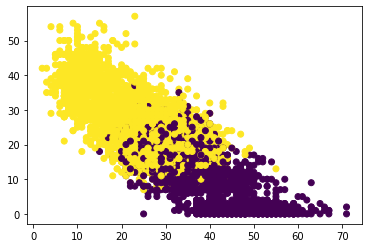

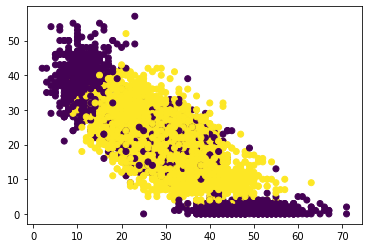

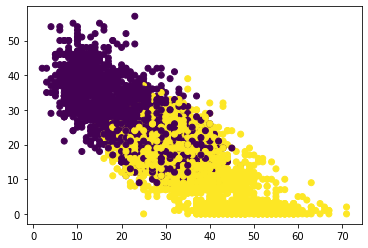

In [383]:
X, y = make_multilabel_classification(5000, 2, 3, allow_unlabeled=False)

plt.scatter(X[:,0], X[:,1], c=y[:,0])
plt.show()
plt.scatter(X[:,0], X[:,1], c=y[:,1])
plt.show()
plt.scatter(X[:,0], X[:,1], c=y[:,2])
plt.show()

In [384]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3750, 2) (1250, 2)
(3750, 3) (1250, 3)


In [292]:
epistemic_model_1 = create_epistemic_model()
epistemic_model_1 = train_model(X_train, X_test, y_train[:,0], y_test[:,0], epistemic_model_1 ,epochs=300, verbose=0)

epistemic_model_2 = create_epistemic_model()
epistemic_model_2 = train_model(X_train, X_test, y_train[:,1], y_test[:,1], epistemic_model_2 ,epochs=300, verbose=0)

epistemic_model_3 = create_epistemic_model()
epistemic_model_3 = train_model(X_train, X_test, y_train[:,2], y_test[:,2], epistemic_model_3 ,epochs=300, verbose=0)

Model: "epistemic_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_variational_140 (Dens  (None, 100)              600       
 eVariational)                                                   
                                                                 
 dense_variational_141 (Dens  (None, 100)              20200     
 eVariational)                                                   
                                                                 
 dense_variational_142 (Dens  (None, 1)                202       
 eVariational)                                                   
                                                                 
Total params: 21,002
Trainable params: 21,002
Non-trainable params: 0
_________________________________________________

accuracy :  0.5344
AUC :  0.5932272053830483
accuracy :  0.6704
AUC :  0.6323669972426257
accuracy :  0.6544
AUC :  0.26514958571040476


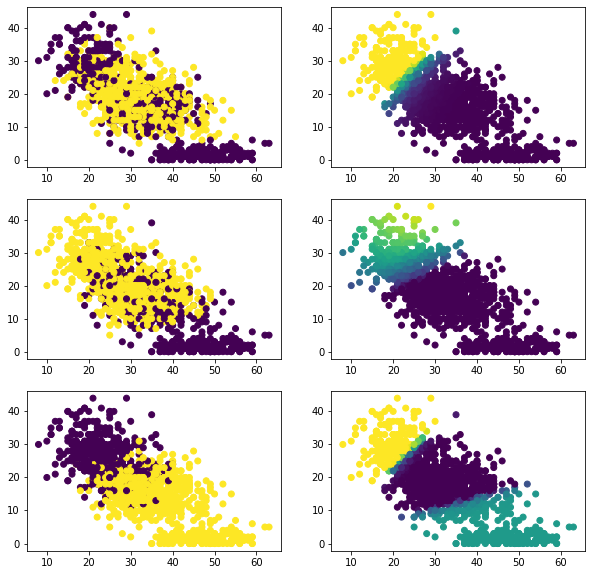

In [295]:
y_pred_1, y_std = infer(X_test, y_test[:,0], epistemic_model_1)
y_pred_2, y_std = infer(X_test, y_test[:,1], epistemic_model_2)
y_pred_3, y_std = infer(X_test, y_test[:,2], epistemic_model_3)

fig= plt.figure(figsize=(10, 10))

plt.subplot(3,2,1)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test[:,0])

plt.subplot(3,2,2)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred_1)

plt.subplot(3,2,3)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test[:,1])

plt.subplot(3,2,4)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred_2)

plt.subplot(3,2,5)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test[:,2])

plt.subplot(3,2,6)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred_3)

In [393]:
multilabel_epistemic_model = create_multilabel_epistemic_model()
multilabel_epistemic_model = train_model(X_train, X_test, y_train, y_test, multilabel_epistemic_model, epochs=100, verbose=1)

Model: "epistemic_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_84 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_variational_193 (Dens  (None, 100)              600       
 eVariational)                                                   
                                                                 
 dense_variational_194 (Dens  (None, 100)              20200     
 eVariational)                                                   
                                                                 
 dense_variational_195 (Dens  (None, 3)                606       
 eVariational)                                                   
                                                                 
Total params: 21,406
Trainable params: 21,406
Non-trainable params: 0
_________________________________________________

In [388]:
def infer(X_test, y_test, model_, it=10): 
  y_preds = []
  for _ in range(it): 
    y_preds.append(model_(X_test))
  
  pred_mean = np.mean(y_preds, axis=0)
  pred_stdv = np.std(y_preds, axis=0)
  
  auc = AUC(name='AUC_ROC', curve='ROC', multi_label=True)
  auc.update_state(y_test, pred_mean)

 # precision, recall, _ , _ = precision_recall_fscore_support(y_test, pred_mean.round(), average='weighted')
  
  #print('precision, recall', precision, recall)
  print('AUC : ', auc.result().numpy())

  return pred_mean, pred_stdv

AUC :  0.87542224


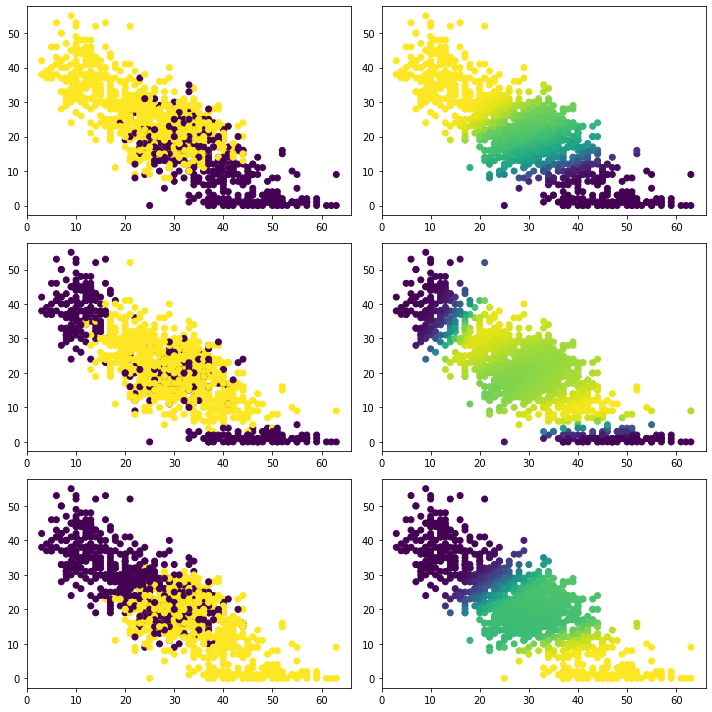

In [394]:
y_pred, y_std = infer(X_test, y_test,  multilabel_epistemic_model)

fig= plt.figure(figsize=(10, 10))

plt.subplot(3,2,1)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test[:,0])

plt.subplot(3,2,2)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred[:,0])

plt.subplot(3,2,3)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test[:,1])

plt.subplot(3,2,4)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred[:,1])

plt.subplot(3,2,5)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test[:,2])

plt.subplot(3,2,6)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred[:,2])

plt.tight_layout()

## epistemic regression

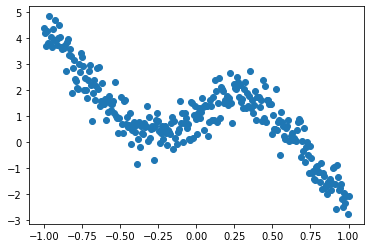

In [217]:
X = np.linspace(-1, 1, 300)
y = 4 * X * np.cos(np.pi * np.sin(X)) + 1 + np.random.randn(X.shape[0]) * 0.5
plt.scatter(X, y)

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(225,) (75,)
(225,) (75,)


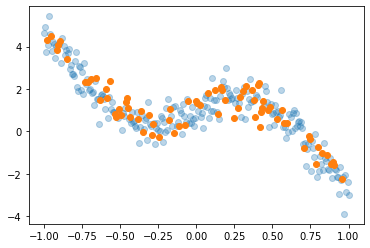

In [371]:
plt.scatter(X_train, y_train, alpha=0.3)
plt.scatter(X_test, y_test)

In [103]:
# Prior is not trainable
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return Sequential([
       tfp.layers.DistributionLambda(
           lambda t: tfd.Laplace(loc = tf.zeros(n), scale= 2 * tf.ones(n))
       )                     
  ])

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(

          tfd.Normal(loc=t[..., :n],
                     scale= 1e-5 + 0.003 * tf.nn.softplus(t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

In [203]:
def epistemic_regressor():
  inputs = keras.Input(shape=(1,))

  x = tfp.layers.DenseVariational(units=128, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(inputs)
  
  x = tfp.layers.DenseVariational(units=64, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0],
                                  activation='relu')(x)
                    
  outputs = tfp.layers.DenseVariational(units=1, 
                                  make_prior_fn=prior,
                                  make_posterior_fn=posterior,
                                  kl_weight = 1 / X_train.shape[0])(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name='epistemic_BNN')

  opt = keras.optimizers.Adam(learning_rate=0.001)

  model.compile(loss='mse', optimizer=opt)
  model.summary()

  return model
  

In [202]:
def train_regressor(X_train, X_test, y_train, y_test, model, epochs=100, batch_size=32, verbose=0):
  device_name = tf.test.gpu_device_name()
  if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
  else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

  with tf.device(device_name):
    model.fit(X_train, y_train, batch_size=batch_size, verbose=verbose, epochs=epochs, 
                                validation_data=(X_test, y_test),) 
    
    
  return model 

In [205]:
regressor = epistemic_regressor()
regressor = train_regressor(X_train, X_test, y_train, y_test, regressor, verbose=1, epochs=2000)

Model: "epistemic_BNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_variational_10 (Dense  (None, 128)              512       
 Variational)                                                    
                                                                 
 dense_variational_11 (Dense  (None, 64)               16512     
 Variational)                                                    
                                                                 
 dense_variational_12 (Dense  (None, 1)                130       
 Variational)                                                    
                                                                 
Total params: 17,154
Trainable params: 17,154
Non-trainable params: 0
_________________________________________________

8/8 [==============================] - 0s 4ms/step - loss: 1243050.3750 - val_loss: 1241332.2500
Epoch 138/2000
8/8 [==============================] - 0s 4ms/step - loss: 1240920.0000 - val_loss: 1242470.0000
Epoch 139/2000
8/8 [==============================] - 0s 4ms/step - loss: 1241562.5000 - val_loss: 1238588.2500
Epoch 140/2000
8/8 [==============================] - 0s 4ms/step - loss: 1238054.1250 - val_loss: 1238285.5000
Epoch 141/2000
8/8 [==============================] - 0s 4ms/step - loss: 1238738.2500 - val_loss: 1235728.0000
Epoch 142/2000
8/8 [==============================] - 0s 4ms/step - loss: 1236759.6250 - val_loss: 1237192.3750
Epoch 143/2000
8/8 [==============================] - 0s 4ms/step - loss: 1236092.0000 - val_loss: 1233981.8750
Epoch 144/2000
8/8 [==============================] - 0s 4ms/step - loss: 1233634.0000 - val_loss: 1234341.7500
Epoch 145/2000
8/8 [==============================] - 0s 4ms/step - loss: 1234802.3750 - val_loss: 1231456.3750
Epoch 1

8/8 [==============================] - 0s 4ms/step - loss: 1100497.1250 - val_loss: 1097284.0000
Epoch 284/2000
8/8 [==============================] - 0s 4ms/step - loss: 1100528.3750 - val_loss: 1097513.5000
Epoch 285/2000
8/8 [==============================] - 0s 4ms/step - loss: 1098104.5000 - val_loss: 1095923.0000
Epoch 286/2000
8/8 [==============================] - 0s 4ms/step - loss: 1097462.0000 - val_loss: 1097005.7500
Epoch 287/2000
8/8 [==============================] - 0s 4ms/step - loss: 1097111.2500 - val_loss: 1093925.3750
Epoch 288/2000
8/8 [==============================] - 0s 4ms/step - loss: 1095082.1250 - val_loss: 1094128.0000
Epoch 289/2000
8/8 [==============================] - 0s 4ms/step - loss: 1093357.8750 - val_loss: 1092120.3750
Epoch 290/2000
8/8 [==============================] - 0s 4ms/step - loss: 1093928.0000 - val_loss: 1093034.8750
Epoch 291/2000
8/8 [==============================] - 0s 4ms/step - loss: 1092891.6250 - val_loss: 1091100.0000
Epoch 2

8/8 [==============================] - 0s 4ms/step - loss: 996702.0625 - val_loss: 998554.8750
Epoch 430/2000
8/8 [==============================] - 0s 4ms/step - loss: 997825.4375 - val_loss: 998688.6250
Epoch 431/2000
8/8 [==============================] - 0s 4ms/step - loss: 997623.6875 - val_loss: 998320.1875
Epoch 432/2000
8/8 [==============================] - 0s 4ms/step - loss: 994709.8750 - val_loss: 993243.8125
Epoch 433/2000
8/8 [==============================] - 0s 4ms/step - loss: 994788.2500 - val_loss: 993552.4375
Epoch 434/2000
8/8 [==============================] - 0s 4ms/step - loss: 993193.2500 - val_loss: 994893.7500
Epoch 435/2000
8/8 [==============================] - 0s 4ms/step - loss: 994514.7500 - val_loss: 994087.0625
Epoch 436/2000
8/8 [==============================] - 0s 4ms/step - loss: 993330.7500 - val_loss: 993710.3750
Epoch 437/2000
8/8 [==============================] - 0s 4ms/step - loss: 993472.1250 - val_loss: 991545.5000
Epoch 438/2000
8/8 [=====

8/8 [==============================] - 0s 4ms/step - loss: 918858.8750 - val_loss: 916156.0625
Epoch 578/2000
8/8 [==============================] - 0s 4ms/step - loss: 917322.3750 - val_loss: 919258.0000
Epoch 579/2000
8/8 [==============================] - 0s 4ms/step - loss: 917082.9375 - val_loss: 915428.9375
Epoch 580/2000
8/8 [==============================] - 0s 4ms/step - loss: 915553.0000 - val_loss: 914668.9375
Epoch 581/2000
8/8 [==============================] - 0s 4ms/step - loss: 914881.2500 - val_loss: 917174.5000
Epoch 582/2000
8/8 [==============================] - 0s 4ms/step - loss: 915740.8750 - val_loss: 917185.9375
Epoch 583/2000
8/8 [==============================] - 0s 4ms/step - loss: 915946.1250 - val_loss: 914638.3125
Epoch 584/2000
8/8 [==============================] - 0s 4ms/step - loss: 915846.5000 - val_loss: 913551.0625
Epoch 585/2000
8/8 [==============================] - 0s 4ms/step - loss: 913335.6875 - val_loss: 912751.2500
Epoch 586/2000
8/8 [=====

8/8 [==============================] - 0s 4ms/step - loss: 853174.8125 - val_loss: 852823.1250
Epoch 726/2000
8/8 [==============================] - 0s 4ms/step - loss: 852670.2500 - val_loss: 850248.8750
Epoch 727/2000
8/8 [==============================] - 0s 4ms/step - loss: 853051.8750 - val_loss: 853064.4375
Epoch 728/2000
8/8 [==============================] - 0s 4ms/step - loss: 852791.5625 - val_loss: 851500.5625
Epoch 729/2000
8/8 [==============================] - 0s 4ms/step - loss: 851106.5625 - val_loss: 849323.0625
Epoch 730/2000
8/8 [==============================] - 0s 4ms/step - loss: 851124.9375 - val_loss: 853640.3125
Epoch 731/2000
8/8 [==============================] - 0s 4ms/step - loss: 850333.8750 - val_loss: 849278.7500
Epoch 732/2000
8/8 [==============================] - 0s 4ms/step - loss: 851893.5625 - val_loss: 848982.7500
Epoch 733/2000
8/8 [==============================] - 0s 4ms/step - loss: 849629.3125 - val_loss: 848858.5625
Epoch 734/2000
8/8 [=====

8/8 [==============================] - 0s 4ms/step - loss: 796931.0625 - val_loss: 799169.9375
Epoch 874/2000
8/8 [==============================] - 0s 4ms/step - loss: 799409.8750 - val_loss: 795235.8125
Epoch 875/2000
8/8 [==============================] - 0s 4ms/step - loss: 797552.0000 - val_loss: 796991.1250
Epoch 876/2000
8/8 [==============================] - 0s 4ms/step - loss: 797941.0625 - val_loss: 797459.0000
Epoch 877/2000
8/8 [==============================] - 0s 4ms/step - loss: 796578.3750 - val_loss: 797363.2500
Epoch 878/2000
8/8 [==============================] - 0s 4ms/step - loss: 798072.5625 - val_loss: 794705.5000
Epoch 879/2000
8/8 [==============================] - 0s 4ms/step - loss: 796732.0000 - val_loss: 794900.4375
Epoch 880/2000
8/8 [==============================] - 0s 4ms/step - loss: 795751.8125 - val_loss: 797483.0000
Epoch 881/2000
8/8 [==============================] - 0s 4ms/step - loss: 797609.9375 - val_loss: 795519.0625
Epoch 882/2000
8/8 [=====

8/8 [==============================] - 0s 4ms/step - loss: 750508.4375 - val_loss: 753044.2500
Epoch 1022/2000
8/8 [==============================] - 0s 4ms/step - loss: 751190.0000 - val_loss: 753590.8750
Epoch 1023/2000
8/8 [==============================] - 0s 4ms/step - loss: 749881.6875 - val_loss: 749289.0000
Epoch 1024/2000
8/8 [==============================] - 0s 4ms/step - loss: 750117.6875 - val_loss: 749043.8125
Epoch 1025/2000
8/8 [==============================] - 0s 4ms/step - loss: 748805.6250 - val_loss: 751067.6250
Epoch 1026/2000
8/8 [==============================] - 0s 4ms/step - loss: 749093.2500 - val_loss: 749518.3750
Epoch 1027/2000
8/8 [==============================] - 0s 4ms/step - loss: 748860.5625 - val_loss: 747959.9375
Epoch 1028/2000
8/8 [==============================] - 0s 4ms/step - loss: 747814.0000 - val_loss: 750259.8125
Epoch 1029/2000
8/8 [==============================] - 0s 4ms/step - loss: 749199.3125 - val_loss: 747686.7500
Epoch 1030/2000
8

Epoch 1095/2000
8/8 [==============================] - 0s 4ms/step - loss: 729744.0625 - val_loss: 730731.8125
Epoch 1096/2000
8/8 [==============================] - 0s 4ms/step - loss: 729014.5000 - val_loss: 730090.1875
Epoch 1097/2000
8/8 [==============================] - 0s 4ms/step - loss: 727920.6250 - val_loss: 727128.8125
Epoch 1098/2000
8/8 [==============================] - 0s 4ms/step - loss: 727261.1250 - val_loss: 728624.9375
Epoch 1099/2000
8/8 [==============================] - 0s 4ms/step - loss: 727598.3750 - val_loss: 727253.5000
Epoch 1100/2000
8/8 [==============================] - 0s 4ms/step - loss: 727323.3750 - val_loss: 726691.1875
Epoch 1101/2000
8/8 [==============================] - 0s 4ms/step - loss: 728786.6250 - val_loss: 726740.1250
Epoch 1102/2000
8/8 [==============================] - 0s 4ms/step - loss: 726492.8750 - val_loss: 725635.0000
Epoch 1103/2000
8/8 [==============================] - 0s 4ms/step - loss: 726547.1875 - val_loss: 728471.8125
E

Epoch 1169/2000
8/8 [==============================] - 0s 4ms/step - loss: 708230.2500 - val_loss: 707785.6250
Epoch 1170/2000
8/8 [==============================] - 0s 4ms/step - loss: 709618.8750 - val_loss: 711527.1250
Epoch 1171/2000
8/8 [==============================] - 0s 4ms/step - loss: 708570.6875 - val_loss: 706641.5625
Epoch 1172/2000
8/8 [==============================] - 0s 4ms/step - loss: 708616.1250 - val_loss: 703705.0625
Epoch 1173/2000
8/8 [==============================] - 0s 4ms/step - loss: 707843.7500 - val_loss: 707953.8125
Epoch 1174/2000
8/8 [==============================] - 0s 4ms/step - loss: 706221.7500 - val_loss: 706504.5625
Epoch 1175/2000
8/8 [==============================] - 0s 4ms/step - loss: 707639.8125 - val_loss: 708819.0625
Epoch 1176/2000
8/8 [==============================] - 0s 4ms/step - loss: 707712.9375 - val_loss: 707345.8125
Epoch 1177/2000
8/8 [==============================] - 0s 4ms/step - loss: 707869.3750 - val_loss: 707547.3750
E

Epoch 1243/2000
8/8 [==============================] - 0s 4ms/step - loss: 689746.5000 - val_loss: 690704.1875
Epoch 1244/2000
8/8 [==============================] - 0s 4ms/step - loss: 689588.7500 - val_loss: 687777.0000
Epoch 1245/2000
8/8 [==============================] - 0s 4ms/step - loss: 690047.6250 - val_loss: 690014.1250
Epoch 1246/2000
8/8 [==============================] - 0s 4ms/step - loss: 688976.4375 - val_loss: 687990.5625
Epoch 1247/2000
8/8 [==============================] - 0s 4ms/step - loss: 686939.3125 - val_loss: 688539.6875
Epoch 1248/2000
8/8 [==============================] - 0s 4ms/step - loss: 685912.6875 - val_loss: 684986.5625
Epoch 1249/2000
8/8 [==============================] - 0s 4ms/step - loss: 687881.1875 - val_loss: 688477.4375
Epoch 1250/2000
8/8 [==============================] - 0s 4ms/step - loss: 688180.2500 - val_loss: 688814.5625
Epoch 1251/2000
8/8 [==============================] - 0s 4ms/step - loss: 687167.5625 - val_loss: 687571.8125
E

Epoch 1317/2000
8/8 [==============================] - 0s 4ms/step - loss: 671153.1875 - val_loss: 674043.8125
Epoch 1318/2000
8/8 [==============================] - 0s 4ms/step - loss: 670714.6875 - val_loss: 671751.0625
Epoch 1319/2000
8/8 [==============================] - 0s 4ms/step - loss: 671698.2500 - val_loss: 671379.5000
Epoch 1320/2000
8/8 [==============================] - 0s 4ms/step - loss: 671379.1250 - val_loss: 667670.6250
Epoch 1321/2000
8/8 [==============================] - 0s 4ms/step - loss: 670396.3750 - val_loss: 668743.8125
Epoch 1322/2000
8/8 [==============================] - 0s 4ms/step - loss: 670336.8750 - val_loss: 671471.6250
Epoch 1323/2000
8/8 [==============================] - 0s 4ms/step - loss: 669397.6875 - val_loss: 667901.2500
Epoch 1324/2000
8/8 [==============================] - 0s 4ms/step - loss: 667884.2500 - val_loss: 671810.3125
Epoch 1325/2000
8/8 [==============================] - 0s 4ms/step - loss: 669272.6250 - val_loss: 668258.5000
E

Epoch 1391/2000
8/8 [==============================] - 0s 4ms/step - loss: 653367.8750 - val_loss: 652151.5625
Epoch 1392/2000
8/8 [==============================] - 0s 4ms/step - loss: 652317.4375 - val_loss: 652237.5625
Epoch 1393/2000
8/8 [==============================] - 0s 4ms/step - loss: 655852.5000 - val_loss: 652950.1875
Epoch 1394/2000
8/8 [==============================] - 0s 4ms/step - loss: 651222.3125 - val_loss: 652913.0000
Epoch 1395/2000
8/8 [==============================] - 0s 4ms/step - loss: 652086.5000 - val_loss: 653962.7500
Epoch 1396/2000
8/8 [==============================] - 0s 4ms/step - loss: 651383.1875 - val_loss: 652008.8750
Epoch 1397/2000
8/8 [==============================] - 0s 4ms/step - loss: 651682.0625 - val_loss: 652557.8750
Epoch 1398/2000
8/8 [==============================] - 0s 4ms/step - loss: 651591.9375 - val_loss: 650373.1875
Epoch 1399/2000
8/8 [==============================] - 0s 4ms/step - loss: 651791.3750 - val_loss: 651272.1875
E

Epoch 1465/2000
8/8 [==============================] - 0s 4ms/step - loss: 637386.0000 - val_loss: 635547.7500
Epoch 1466/2000
8/8 [==============================] - 0s 4ms/step - loss: 637163.5000 - val_loss: 640048.0625
Epoch 1467/2000
8/8 [==============================] - 0s 4ms/step - loss: 635369.7500 - val_loss: 638938.7500
Epoch 1468/2000
8/8 [==============================] - 0s 4ms/step - loss: 637350.3750 - val_loss: 636556.9375
Epoch 1469/2000
8/8 [==============================] - 0s 4ms/step - loss: 636892.5625 - val_loss: 636307.9375
Epoch 1470/2000
8/8 [==============================] - 0s 4ms/step - loss: 635735.4375 - val_loss: 637155.8125
Epoch 1471/2000
8/8 [==============================] - 0s 4ms/step - loss: 636653.5625 - val_loss: 633044.7500
Epoch 1472/2000
8/8 [==============================] - 0s 4ms/step - loss: 635520.8125 - val_loss: 637610.1250
Epoch 1473/2000
8/8 [==============================] - 0s 4ms/step - loss: 635624.8750 - val_loss: 634857.6250
E

Epoch 1539/2000
8/8 [==============================] - 0s 4ms/step - loss: 619249.5625 - val_loss: 623471.0625
Epoch 1540/2000
8/8 [==============================] - 0s 4ms/step - loss: 622468.1875 - val_loss: 620635.3125
Epoch 1541/2000
8/8 [==============================] - 0s 4ms/step - loss: 621292.8750 - val_loss: 621386.8750
Epoch 1542/2000
8/8 [==============================] - 0s 4ms/step - loss: 620376.5625 - val_loss: 620108.5625
Epoch 1543/2000
8/8 [==============================] - 0s 4ms/step - loss: 619203.4375 - val_loss: 618885.4375
Epoch 1544/2000
8/8 [==============================] - 0s 4ms/step - loss: 621108.6250 - val_loss: 620712.3125
Epoch 1545/2000
8/8 [==============================] - 0s 4ms/step - loss: 619300.0625 - val_loss: 620970.3125
Epoch 1546/2000
8/8 [==============================] - 0s 4ms/step - loss: 619666.3750 - val_loss: 618763.0000
Epoch 1547/2000
8/8 [==============================] - 0s 4ms/step - loss: 618669.6250 - val_loss: 618335.3750
E

Epoch 1613/2000
8/8 [==============================] - 0s 4ms/step - loss: 606600.7500 - val_loss: 603659.0625
Epoch 1614/2000
8/8 [==============================] - 0s 4ms/step - loss: 608369.4375 - val_loss: 606744.8125
Epoch 1615/2000
8/8 [==============================] - 0s 4ms/step - loss: 605320.3125 - val_loss: 602264.3125
Epoch 1616/2000
8/8 [==============================] - 0s 4ms/step - loss: 605480.8750 - val_loss: 606040.6875
Epoch 1617/2000
8/8 [==============================] - 0s 4ms/step - loss: 604412.1875 - val_loss: 603235.7500
Epoch 1618/2000
8/8 [==============================] - 0s 4ms/step - loss: 604028.0000 - val_loss: 606080.5625
Epoch 1619/2000
8/8 [==============================] - 0s 4ms/step - loss: 603964.8125 - val_loss: 606047.4375
Epoch 1620/2000
8/8 [==============================] - 0s 4ms/step - loss: 603783.9375 - val_loss: 606182.6875
Epoch 1621/2000
8/8 [==============================] - 0s 4ms/step - loss: 602772.0000 - val_loss: 605265.3125
E

Epoch 1687/2000
8/8 [==============================] - 0s 4ms/step - loss: 590786.1250 - val_loss: 590266.6250
Epoch 1688/2000
8/8 [==============================] - 0s 4ms/step - loss: 591106.1875 - val_loss: 590366.6875
Epoch 1689/2000
8/8 [==============================] - 0s 4ms/step - loss: 590575.4375 - val_loss: 593435.5625
Epoch 1690/2000
8/8 [==============================] - 0s 4ms/step - loss: 592015.0000 - val_loss: 590436.6250
Epoch 1691/2000
8/8 [==============================] - 0s 4ms/step - loss: 589963.0625 - val_loss: 590862.8750
Epoch 1692/2000
8/8 [==============================] - 0s 4ms/step - loss: 589451.5000 - val_loss: 588554.8125
Epoch 1693/2000
8/8 [==============================] - 0s 4ms/step - loss: 589950.3125 - val_loss: 592740.1250
Epoch 1694/2000
8/8 [==============================] - 0s 4ms/step - loss: 589885.8750 - val_loss: 590096.8750
Epoch 1695/2000
8/8 [==============================] - 0s 4ms/step - loss: 589655.8125 - val_loss: 587964.1875
E

Epoch 1761/2000
8/8 [==============================] - 0s 4ms/step - loss: 576306.6250 - val_loss: 576664.1250
Epoch 1762/2000
8/8 [==============================] - 0s 4ms/step - loss: 577105.4375 - val_loss: 577484.8125
Epoch 1763/2000
8/8 [==============================] - 0s 4ms/step - loss: 576837.5000 - val_loss: 576796.6250
Epoch 1764/2000
8/8 [==============================] - 0s 4ms/step - loss: 576990.6250 - val_loss: 577447.9375
Epoch 1765/2000
8/8 [==============================] - 0s 4ms/step - loss: 576647.7500 - val_loss: 577576.1875
Epoch 1766/2000
8/8 [==============================] - 0s 4ms/step - loss: 576674.5000 - val_loss: 575671.0000
Epoch 1767/2000
8/8 [==============================] - 0s 4ms/step - loss: 575940.5625 - val_loss: 575026.7500
Epoch 1768/2000
8/8 [==============================] - 0s 4ms/step - loss: 575004.9375 - val_loss: 573340.6875
Epoch 1769/2000
8/8 [==============================] - 0s 4ms/step - loss: 575943.4375 - val_loss: 574569.6250
E

Epoch 1835/2000
8/8 [==============================] - 0s 4ms/step - loss: 563635.5625 - val_loss: 567140.1875
Epoch 1836/2000
8/8 [==============================] - 0s 4ms/step - loss: 563307.9375 - val_loss: 562122.7500
Epoch 1837/2000
8/8 [==============================] - 0s 4ms/step - loss: 563907.0625 - val_loss: 559996.8125
Epoch 1838/2000
8/8 [==============================] - 0s 4ms/step - loss: 564540.1875 - val_loss: 564405.5000
Epoch 1839/2000
8/8 [==============================] - 0s 4ms/step - loss: 564496.8750 - val_loss: 564952.8125
Epoch 1840/2000
8/8 [==============================] - 0s 4ms/step - loss: 564269.3750 - val_loss: 563882.7500
Epoch 1841/2000
8/8 [==============================] - 0s 4ms/step - loss: 563042.2500 - val_loss: 561661.2500
Epoch 1842/2000
8/8 [==============================] - 0s 4ms/step - loss: 563169.8750 - val_loss: 564137.9375
Epoch 1843/2000
8/8 [==============================] - 0s 4ms/step - loss: 563015.3750 - val_loss: 561858.2500
E

Epoch 1909/2000
8/8 [==============================] - 0s 4ms/step - loss: 553002.6250 - val_loss: 553562.5000
Epoch 1910/2000
8/8 [==============================] - 0s 4ms/step - loss: 550072.6875 - val_loss: 552572.6875
Epoch 1911/2000
8/8 [==============================] - 0s 4ms/step - loss: 551170.6875 - val_loss: 549317.1875
Epoch 1912/2000
8/8 [==============================] - 0s 4ms/step - loss: 550275.8125 - val_loss: 549150.9375
Epoch 1913/2000
8/8 [==============================] - 0s 4ms/step - loss: 550419.6875 - val_loss: 551873.2500
Epoch 1914/2000
8/8 [==============================] - 0s 4ms/step - loss: 551007.1875 - val_loss: 549316.8750
Epoch 1915/2000
8/8 [==============================] - 0s 4ms/step - loss: 550401.7500 - val_loss: 548997.8125
Epoch 1916/2000
8/8 [==============================] - 0s 4ms/step - loss: 549887.4375 - val_loss: 548378.5625
Epoch 1917/2000
8/8 [==============================] - 0s 4ms/step - loss: 549509.5625 - val_loss: 550903.8125
E

Epoch 1983/2000
8/8 [==============================] - 0s 4ms/step - loss: 539521.8750 - val_loss: 540367.8125
Epoch 1984/2000
8/8 [==============================] - 0s 4ms/step - loss: 538468.9375 - val_loss: 539752.5625
Epoch 1985/2000
8/8 [==============================] - 0s 4ms/step - loss: 537164.2500 - val_loss: 538776.0000
Epoch 1986/2000
8/8 [==============================] - 0s 4ms/step - loss: 539270.0625 - val_loss: 539925.4375
Epoch 1987/2000
8/8 [==============================] - 0s 4ms/step - loss: 538661.3750 - val_loss: 537635.8125
Epoch 1988/2000
8/8 [==============================] - 0s 4ms/step - loss: 539571.7500 - val_loss: 539656.6875
Epoch 1989/2000
8/8 [==============================] - 0s 4ms/step - loss: 537331.1875 - val_loss: 537959.0625
Epoch 1990/2000
8/8 [==============================] - 0s 4ms/step - loss: 537211.8125 - val_loss: 537631.8125
Epoch 1991/2000
8/8 [==============================] - 0s 4ms/step - loss: 537210.3125 - val_loss: 535850.0000
E

In [358]:
print(regressor(tf.convert_to_tensor([1])))

tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


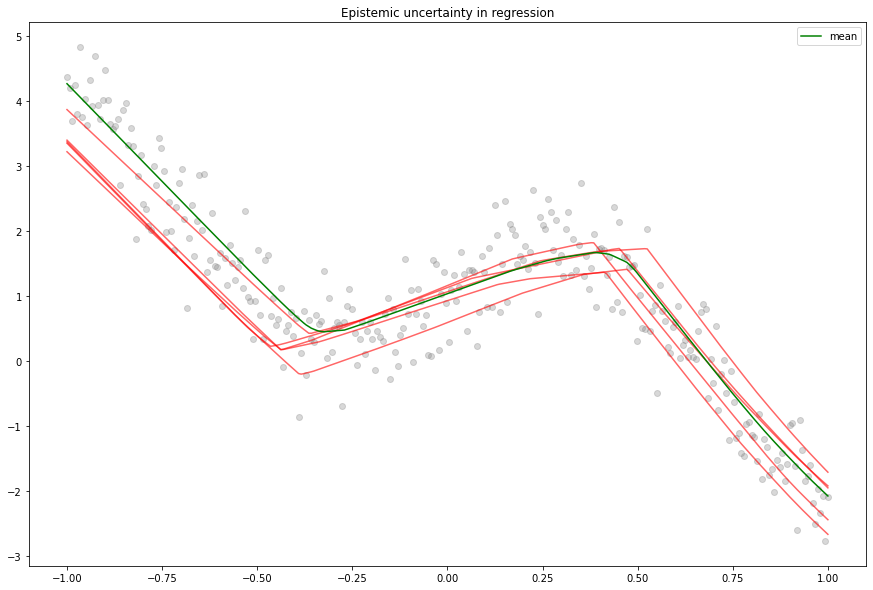

In [218]:
plt.figure(figsize=(15, 10))
plt.scatter(X, y, marker='o', color='gray', alpha=0.3)
y_pred = 0
for _ in range(5):
  y_pred +=  regressor(X)
  plt.plot(X, regressor(X), color='red', alpha=0.6)

plt.plot(X, y_pred/5, color='green', label='mean')
plt.legend()
plt.title('Epistemic uncertainty in regression')
plt.savefig('figs/epistemic_uncertainty_rgn.png')

In [1]:
from sklearn.datasets import make_blobs 

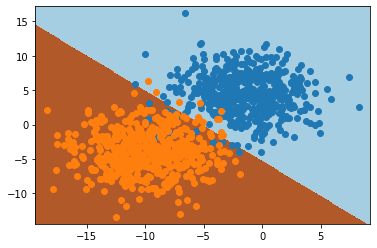

In [55]:
from sklearn.linear_model import LogisticRegression

# generate dataset
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=1, cluster_std=3)
# define bounds of the domain
min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# make predictions for the grid
yhat = model.predict(grid)
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)
# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz, cmap='Paired')
# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y == class_value)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')

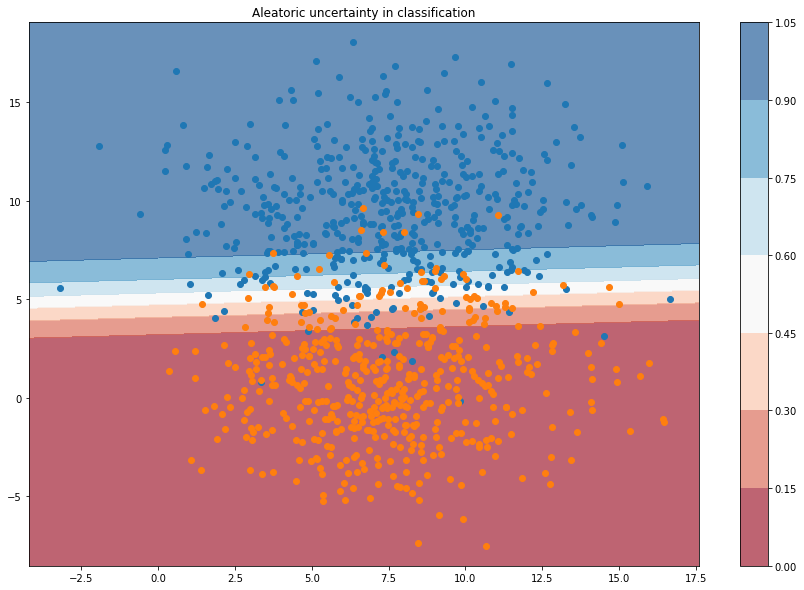

In [196]:
# probability decision surface for logistic regression on a binary classification dataset
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

fig = plt.figure(figsize=(15,10))

# generate dataset
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=8, cluster_std=3)
# define bounds of the domain
min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# make predictions for the grid
yhat = model.predict_proba(grid)
# keep just the probabilities for class 0
yhat = yhat[:, 0]
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)
# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu', alpha=0.65)
# add a legend, called a color bar
plt.colorbar(c)
# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y == class_value)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='RdBu')
plt.title('Aleatoric uncertainty in classification')
plt.savefig('figs/aleatoric_uncertainty_clf.png')

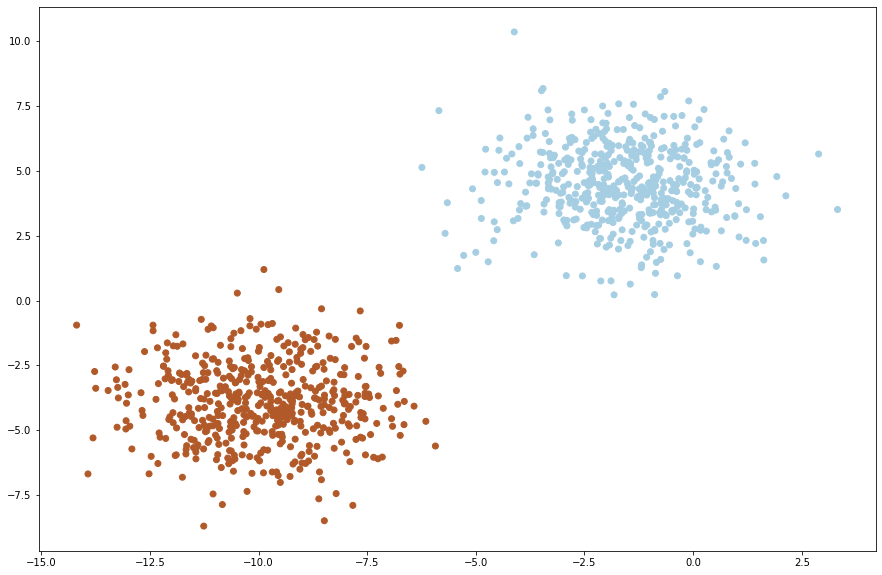

In [220]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=1, cluster_std=1.5)
fig = plt.figure(figsize=(15, 10))
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired')

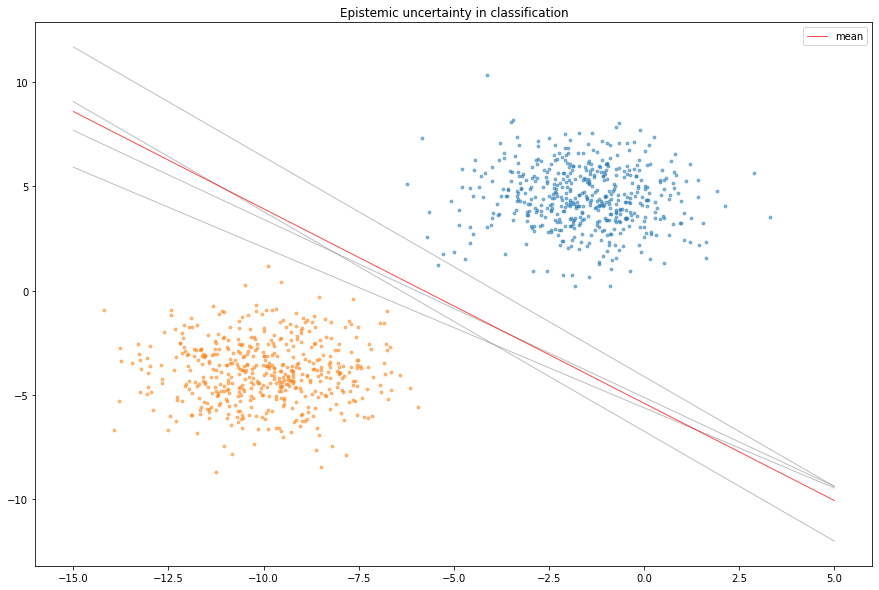

In [223]:
clf = LogisticRegression()
clf.fit(X[:100], y[:100])
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2


xd = np.array([-15, 5])


yd = 1.5+m*xd + c

m = -w1/w2+0.2
yd_2 = .5+m*xd + c

m = -w1/w2
yd_3 = m*xd + 1.2*c

m = -(0.73*w1)/w2
yd_4 = m*xd + c

mean = np.mean([yd, yd_2, yd_3, yd_4], axis=0)

fig = plt.figure(figsize=(15, 10))

plt.plot(xd, yd, 'k', lw=1, color='gray', alpha=0.5)
plt.plot(xd, yd_2, 'k', lw=1, color='gray', alpha=0.5)
plt.plot(xd, yd_3, 'k', lw=1, color='gray', alpha=0.5)
plt.plot(xd, yd_4, 'k', lw=1, color='gray', alpha=0.5)
plt.plot(xd, mean, 'k', lw=1, color='red', alpha=0.7, label='mean')

plt.legend()
plt.scatter(*X[y==0].T, s=8, alpha=0.5)
plt.scatter(*X[y==1].T, s=8, alpha=0.5)
plt.title('Epistemic uncertainty in classification')
plt.savefig('figs/epistemic_uncertainty_clf.png')